In [1]:
import os
import math
import random
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import pycocotools
from torch.utils.tensorboard import SummaryWriter

In [2]:
# if torch.cuda.is_available():  
#     device = "cuda:0" 
# else:  
#     device = "cpu" 
    
# torch.cuda.current_device()

In [3]:
# Code from Maastricht to access GPU of choice

import torch
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'


In [4]:
torch.cuda.set_device(0)
device = torch.device(f'cuda:{0}' if torch.cuda.is_available() else 'cpu')


In [5]:
torch.cuda.current_device(), torch.cuda.get_device_name()

(0, 'GeForce GTX 1080 Ti')

## Import data

In [6]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode


# Class for a customized dataset
# In this case preprocessed CEM images combined in a 3-channel RGB .jpg format
# and the corresponding mask of present lesions in a 1-channel .png format
class CustomImageDataset(Dataset):
    def __init__(self, root, annotations_file, img_dir, mask_dir, train=False, transform=None, target_transform=None):
        # Read the .csv file with all the information
        self.img_labels = pd.read_csv(os.path.join(root, annotations_file))
        # Define the directories of the images and masks
        self.img_dir = os.path.join(root, img_dir)
        self.mask_dir = os.path.join(root, mask_dir)
        # Define whethet transformations are included
        self.train = train
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        # Return the number of cases in the dataset
        # In this set, CC and MLO of the same breast are considered different cases
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Read the image and the mask for a case from the directories
        img_path = self.img_labels.iloc[idx, 0]
        mask_path = self.img_labels.iloc[idx,6]
        img_path = img_path.replace('E:', '\\\\tsclient\E')
        mask_path = mask_path.replace('E:', '\\\\tsclient\E')
        image = read_image(img_path).float()
        mask = read_image(mask_path)
        
        xmin = self.img_labels.iloc[idx, 1]
        xmax = self.img_labels.iloc[idx, 2]
        ymin = self.img_labels.iloc[idx, 3]
        ymax = self.img_labels.iloc[idx, 4]
        
        # Apply transformations if defined
        flipint = random.random()
        if self.train and flipint > 0.5 :        
            image = T.RandomHorizontalFlip(p=1.0)(image)
            mask = T.RandomHorizontalFlip(p=1.0)(mask)
            
            ymax_temp = image.shape[0] - ymin
            ymin = image.shape[0] - ymax
            ymax = ymax_temp

        # Resize so all images and masks have the same size
#         image = T.Resize([800,800])(image)
#         mask = T.Resize([800,800])(mask)    
#         resize_scale_x = 800/image.size()[1]
#         resize_scale_y = 800/image.size()[2]

        # Resize if necessary
        # First the smallest dimension is reduced to 400 if it is larger
        # Then the largest dimension is reduced to 650 if it is still larger
        resize_scale = 1.0
        min_size_idx = np.argmin([image.size()[1], image.size()[2]])
        
        if min_size_idx == 0 and image.size()[1] > 400 :
            resize_scale *= 400/image.size()[1]
            image = T.Resize([400, int(400*image.size()[2]/image.size()[1])])(image)
            mask = T.Resize([400, int(400*image.size()[2]/image.size()[1])], interpolation=InterpolationMode.NEAREST)(mask)
        if min_size_idx == 0 and image.size()[2] > 650 :
            resize_scale *= 650/image.size()[2]
            image = T.Resize([int(650*image.size()[1]/image.size()[2]), 650])(image)
            mask = T.Resize([int(650*image.size()[1]/image.size()[2]), 650], interpolation=InterpolationMode.NEAREST)(mask)
        
        if min_size_idx == 1 and image.size()[2] > 400 :
            resize_scale *= 400/image.size()[2]
            image = T.Resize([int(400*image.size()[1]/image.size()[2]), 400])(image)
            mask = T.Resize([int(400*image.size()[1]/image.size()[2]), 400], interpolation=InterpolationMode.NEAREST)(mask)
        if min_size_idx == 1 and image.size()[1] > 650 :
            resize_scale *= 650/image.size()[1]
            image = T.Resize([650, int(650*image.size()[2]/image.size()[1])])(image)
            mask = T.Resize([650, int(650*image.size()[2]/image.size()[1])], interpolation=InterpolationMode.NEAREST)(mask)
            
        # Normalize image with mean and standard deviation per channel
        mean = torch.mean(image, dim=(1,2))
        stdev = torch.std(image, dim=(1,2))
        image = T.Normalize(mean, stdev)(image)
        
        # Rescale to [0,1] range per channel
        for dim in range(3) :
            image[dim] -= torch.min(image[dim])
            image[dim] /= torch.max(image[dim])  
        
        # Create separate channel in mask for each lesion
        mask_out = np.zeros((torch.max(mask).item(), mask.shape[-2], mask.shape[-1]))
        for lesion_idx in range(torch.max(mask).item()) :
#             mask_out[lesion_idx][mask[0]==lesion_idx+1] = 1  
            mask_out[lesion_idx][mask[0]>0] = 1 # alternative for wrong masks with only one lesion
        
        # Read the location of the lesion bounding box from the .csv file
        boxes = [[ymin*resize_scale, xmin*resize_scale, ymax*resize_scale, xmax*resize_scale]]
        # Read the label of the lesion from the .csv file
        labels = self.img_labels.iloc[idx, 5]  + 1   # 0 represents background class, thus 1=benign, 2=malignant
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        labels = torch.tensor([labels])
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        mask_out = torch.from_numpy(mask_out)
        mask_out = mask_out.to(torch.uint8)
        
        iscrowd = torch.zeros((2,), dtype=torch.int64)  
            
        target = {}
        target["image_id"] = image_id
        target["masks"] = mask_out
        target["boxes"] = boxes
        target["area"] = area
        target["labels"] = labels
        target["iscrowd"] = iscrowd
            
        return image, target


In [7]:
# import transforms as T

# def get_transform(train=False):
#     transforms = []
#     transforms.append(T.ToTensor())
    
#     if train:
#         transforms.append(T.RandomHorizontalFlip(0.5))
        
#     return T.Compose(transforms)

def get_transform(train=False) :
    if train :
        transforms = torch.nn.Sequential(T.RandomHorizontalFlip(p=0.5))
        
        return transforms
        
    else : 
        return None
    

In [8]:
traindatadir = 'B:\\Astrid\\Preprocessed\\train_set_preprocessedcalc'
trainval_data = CustomImageDataset(traindatadir, 'annotations_train_calccluster_real.csv', 'colored_to_jpg', 'mask_to_png', train=True)

testdatadir = 'B:\\Astrid\\Preprocessed\\test_set_preprocessedcalc'
test_data = CustomImageDataset(testdatadir, 'annotations_test_calccluster_real.csv', 'colored_to_jpg', 'mask_to_png')

savedir = 'B:\\Astrid\\Preprocessed\\ModelsAll'

In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import utils
from torch.utils.data import random_split

# Read training dataset and split in training and validation data
train_data, val_data = random_split(trainval_data, [int(np.floor(len(trainval_data)*0.8)), int(np.ceil(len(trainval_data)*0.2))], generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True, collate_fn=utils.collate_fn)
val_dataloader = DataLoader(val_data, batch_size=4, shuffle=True, collate_fn=utils.collate_fn)

# Read test dataset
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=True, collate_fn=utils.collate_fn)


In [10]:
len(train_data), len(val_data), len(test_data)

(255, 64, 108)

In [11]:
# For Training
train_images, train_targets = next(iter(train_dataloader))
train_image_list = list(image for image in train_images)
train_target_list = [{k: v for k, v in t.items()} for t in train_targets]

# For Validation
val_images, val_targets = next(iter(val_dataloader))
val_image_list = list(image for image in val_images)
val_target_list = [{k: v for k, v in t.items()} for t in val_targets]

# For Testing
test_images, test_targets = next(iter(test_dataloader))
test_image_list = list(image for image in test_images)
test_target_list = [{k: v for k, v in t.items()} for t in test_targets]

In [12]:
val_target_list

[{'image_id': tensor([53]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'boxes': tensor([[ 99.5923, 229.1260, 150.5564, 269.6849]]),
  'area': tensor([2067.0471]),
  'labels': tensor([1]),
  'iscrowd': tensor([0, 0])},
 {'image_id': tensor([157]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'boxes': ten

In [13]:
test_target_list

[{'image_id': tensor([41]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'boxes': tensor([[ 88.1513, 313.9460,  99.8340, 324.5667]]),
  'area': tensor([124.0777]),
  'labels': tensor([2]),
  'iscrowd': tensor([0, 0])},
 {'image_id': tensor([73]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'boxes': tenso

In [14]:
train_targets[0]['image_id'], train_targets[1]['image_id'], train_targets[2]['image_id'], train_targets[3]['image_id']

(tensor([151]), tensor([275]), tensor([130]), tensor([34]))

tensor([151]) tensor([[-215.3118,  476.4888, -170.5082,  508.1273]])
[426, 558, -265, -120]


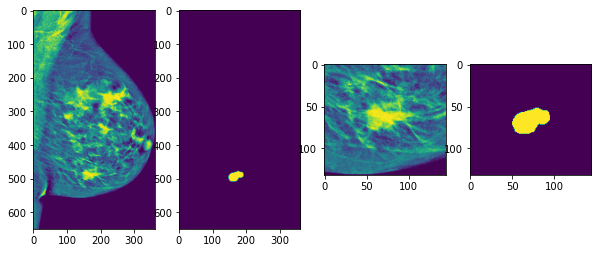

In [15]:
pat_idx = 0
print(train_targets[pat_idx]['image_id'], train_targets[pat_idx]['boxes'])

fig, ax = plt.subplots(1,4, figsize=(10,15))

ax[0].imshow(train_images[pat_idx][0])
ax[1].imshow(train_targets[pat_idx]['masks'][0])

enlarged_box = [int(train_targets[pat_idx]['boxes'][0][1])-50,
                int(train_targets[pat_idx]['boxes'][0][3])+50,
                int(train_targets[pat_idx]['boxes'][0][0])-50,                
                int(train_targets[pat_idx]['boxes'][0][2])+50]
print(enlarged_box)
ax[2].imshow(train_images[pat_idx][0, enlarged_box[0]:enlarged_box[1], enlarged_box[2]:enlarged_box[3]])
ax[3].imshow(train_targets[pat_idx]['masks'][0, enlarged_box[0]:enlarged_box[1], enlarged_box[2]:enlarged_box[3]])

tensor([53]) tensor([[ 99.5923, 229.1260, 150.5564, 269.6849]])
[179, 319, 49, 200]


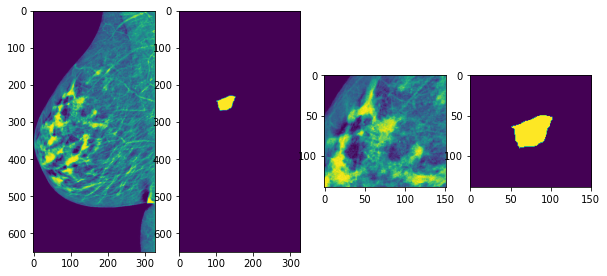

In [16]:
pat_idx = 0
print(val_targets[pat_idx]['image_id'], val_targets[pat_idx]['boxes'])

fig, ax = plt.subplots(1,4, figsize=(10,15))

ax[0].imshow(val_images[pat_idx][0])
ax[1].imshow(val_targets[pat_idx]['masks'][0])

enlarged_box = [int(val_targets[pat_idx]['boxes'][0][1])-50,
                int(val_targets[pat_idx]['boxes'][0][3])+50,
                int(val_targets[pat_idx]['boxes'][0][0])-50,                
                int(val_targets[pat_idx]['boxes'][0][2])+50]
print(enlarged_box)
ax[2].imshow(val_images[pat_idx][0, enlarged_box[0]:enlarged_box[1], enlarged_box[2]:enlarged_box[3]])
ax[3].imshow(val_targets[pat_idx]['masks'][0, enlarged_box[0]:enlarged_box[1], enlarged_box[2]:enlarged_box[3]])

## Define model

In [17]:
import torchvision
from torchvision.models.detection import FasterRCNN, MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# backbone = torchvision.models.resnet50(pretrained=True, progress=True)
# backbone.out_channels = 1000

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

mask_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                     output_size=14,
                                                     sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
# model = FasterRCNN(backbone,
#                    num_classes=3,
#                    rpn_anchor_generator=anchor_generator,
#                    box_roi_pool=roi_pooler)

# put the pieces together inside a MaskRCNN model
model = MaskRCNN(backbone,
                 num_classes=3,
                 rpn_anchor_generator=anchor_generator,
                 box_roi_pool=roi_pooler,
                 mask_roi_pool=mask_roi_pooler,
                 min_size=400,
                 max_size=650)

# import torchvision
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# num_classes = 2

# roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
#                                                 output_size=7,
#                                                 sampling_ratio=2)

# mask_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
#                                                      output_size=14,
#                                                      sampling_ratio=2)

# anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
#                                    aspect_ratios=((0.5, 1.0, 2.0),))

# # load an instance segmentation model pre-trained on COCO
# model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
#                                                            box_roi_pool=roi_pooler,
#                                                            mask_roi_pool=mask_roi_pooler,
#                                                            min_size=400,
#                                                            max_size=650)

# # get number of input features for the classifier
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# # replace the pre-trained head with a new one
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


# # now get the number of input features for the mask classifier
# in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
# hidden_layer = 256
# # and replace the mask predictor with a new one
# model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
#                                                    hidden_layer,
#                                                    num_classes)


In [18]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(400,), max_size=650, mode='bilinear')
  )
  (backbone): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
   

In [19]:
def train_one_epoch_kulum(model, optimizer, train_data_loader, val_data_loader, writer, device, epoch, print_freq, scaler=None):
    
    # Initialise training
    model.train()
    
    # Set up logger to save metrics and losses
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    # Define scheduler for learning rate in optimizer
    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(train_data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    # Read the images and targets from the training data loader
    for images, targets in metric_logger.log_every(train_data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # Compute the losses of the model on these training images and targets
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # Reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
           
        # Write to .tfevents
#         grid = torchvision.utils.make_grid(images)
#         writer.add_image('images', grid, 0)
#         writer.add_graph(model, images)
        
        writer.add_scalar('Loss/train', metric_logger.loss.value, epoch)
        writer.add_scalar('Loss classifier/train', metric_logger.loss_classifier.value, epoch)
        writer.add_scalar('Loss box reg/train', metric_logger.loss_box_reg.value, epoch)
        writer.add_scalar('Loss mask/train', metric_logger.loss_mask.value, epoch)
        writer.add_scalar('Loss objectness/train', metric_logger.loss_objectness.value, epoch)
        writer.add_scalar('Loss rpn box reg/train', metric_logger.loss_rpn_box_reg.value, epoch)
        
    # Set up logger to save metrics and losses of validation
    metric_logger_val = utils.MetricLogger(delimiter="  ")
    metric_logger_val.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
        
    # Read the images and targets from the validation data loader
    for images_val, targets_val in metric_logger_val.log_every(val_data_loader, print_freq, header):
        images_val = list(image.to(device) for image in images_val)
        targets_val = [{k: v.to(device) for k, v in t.items()} for t in targets_val]
        # Compute the losses of the model on these training images and targets
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict_val = model(images_val, targets_val)
            losses_val = sum(loss for loss in loss_dict_val.values())

        # Reduce losses over all GPUs for logging purposes
        loss_dict_reduced_val = utils.reduce_dict(loss_dict_val)
        losses_reduced_val = sum(loss for loss in loss_dict_reduced_val.values())

        loss_value_val = losses_reduced_val.item()
        
        metric_logger_val.update(loss=losses_reduced_val, **loss_dict_reduced_val)
        metric_logger_val.update(lr=optimizer.param_groups[0]["lr"])
        
        writer.add_scalar('Loss/val', metric_logger_val.loss.value, epoch)
        writer.add_scalar('Loss classifier/val', metric_logger_val.loss_classifier.value, epoch)
        writer.add_scalar('Loss box reg/val', metric_logger_val.loss_box_reg.value, epoch)
        writer.add_scalar('Loss mask/val', metric_logger_val.loss_mask.value, epoch)
        writer.add_scalar('Loss objectness/val', metric_logger_val.loss_objectness.value, epoch)
        writer.add_scalar('Loss rpn box reg/val', metric_logger_val.loss_rpn_box_reg.value, epoch)

    return metric_logger, metric_logger_val

def early_stopping_kulum(prev_loss, curr_loss, num_epochs) :
    
    if curr_loss > prev_loss :
        return num_epochs + 1
    else :
        return 0


In [20]:
from engine import train_one_epoch, evaluate

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# model_writer = SummaryWriter('\\\\tsclient\\E\\runs\smallexpsynthetic')
model_writer = SummaryWriter('B:\\Astrid\\Preprocessed\\runs\\15_lrscheduler_benmal')

# let's train it for 10 epochs
num_epochs = 200
logs = []
logs_val = []
min_val_loss = 0.0
stop_epoch = 0

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
#     sample_image, sample_target = sample(next(iter(train_dataloader)))
    
#     sample_image, sample_target = first(train_dataloader)
#     output = self.model(sample_image.to(self.device))
    
    epoch_loss, epoch_loss_val = train_one_epoch_kulum(model, optimizer, train_dataloader, val_dataloader, model_writer, device, epoch, print_freq=10)
#     epoch_loss = train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=10)
    logs.append(epoch_loss)
    logs_val.append(epoch_loss_val)
    
    # update the learning rate
    lr_scheduler.step()
    
    # evaluate on the test dataset
    evaluate(model, val_dataloader, device=device)
    
#     torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'loss': loss,
#                 'loss_classifier': loss_classifier,
#                 'loss_box_reg': loss_box_reg,
#                 'loss_mask': loss_mask,
#                 'loss_objectness': loss_objectness,
#                 'loss_rpn_box': loss_rpn_box
#                 }, savedir)

#     if epoch > 50 :
#         stop_epoch = early_stopping_kulum(min_val_loss, epoch_loss_val.loss.value, stop_epoch)
#         if stop_epoch > 5 :
#             print(f'Early stopping at epoch {epoch} with loss {epoch_loss_val.loss.value}.')

#             break

#         else :
#             min_val_loss = min(min_val_loss, epoch_loss_val.loss.value)
    
    if epoch % 10 == 0 :
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()
                    }, os.path.join(savedir, 'model15_lrscheduler_benmal_'+str(epoch)+'.pth'))
        
model_writer.close()

C:\Users\P70074720\.conda\envs\pytorch36\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [ 0/64]  eta: 0:13:21  lr: 0.000084  loss: 2.6769 (2.6769)  loss_classifier: 1.1296 (1.1296)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.8219 (0.8219)  loss_objectness: 0.7020 (0.7020)  loss_rpn_box_reg: 0.0235 (0.0235)  time: 12.5299  data: 1.2000  max mem: 3317
Epoch: [0]  [10/64]  eta: 0:02:33  lr: 0.000877  loss: 3.1723 (3.3021)  loss_classifier: 0.7248 (0.6840)  loss_box_reg: 0.0001 (0.0003)  loss_mask: 2.0867 (1.7780)  loss_objectness: 0.6868 (0.6769)  loss_rpn_box_reg: 0.1126 (0.1629)  time: 2.8391  data: 1.4344  max mem: 3964
Epoch: [0]  [20/64]  eta: 0:01:36  lr: 0.001670  loss: 2.3180 (2.5562)  loss_classifier: 0.1259 (0.3941)  loss_box_reg: 0.0002 (0.0022)  loss_mask: 1.1105 (1.4370)  loss_objectness: 0.5760 (0.5703)  loss_rpn_box_reg: 0.1015 (0.1526)  time: 1.6773  data: 1.2875  max mem: 3964
Epoch: [0]  [30/64]  eta: 0:01:11  lr: 0.002463  loss: 1.1666 (2.0227)  loss_classifier: 0.0340 (0.2736)  loss_box_reg: 0.0019 (0.0030)  loss_mask: 0.6321 (1.1535)  loss_o

Epoch: [1]  [15/16]  eta: 0:00:01  lr: 0.005000  loss: 0.6404 (0.6169)  loss_classifier: 0.0167 (0.0184)  loss_box_reg: 0.0013 (0.0044)  loss_mask: 0.4835 (0.4877)  loss_objectness: 0.0652 (0.0699)  loss_rpn_box_reg: 0.0157 (0.0366)  time: 1.1211  data: 0.9567  max mem: 5553
Epoch: [1] Total time: 0:00:17 (1.1226 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:22  model_time: 0.1540 (0.1540)  evaluator_time: 0.0070 (0.0070)  time: 1.4280  data: 1.2430  max mem: 5553
Test:  [15/16]  eta: 0:00:01  model_time: 0.1200 (0.1761)  evaluator_time: 0.0050 (0.0046)  time: 1.3182  data: 1.1319  max mem: 5553
Test: Total time: 0:00:21 (1.3184 s / it)
Averaged stats: model_time: 0.1200 (0.1761)  evaluator_time: 0.0050 (0.0046)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | 

Epoch: [3]  [ 0/64]  eta: 0:01:28  lr: 0.000500  loss: 0.3252 (0.3252)  loss_classifier: 0.0073 (0.0073)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.1457 (0.1457)  loss_objectness: 0.0842 (0.0842)  loss_rpn_box_reg: 0.0879 (0.0879)  time: 1.3810  data: 1.0170  max mem: 5553
Epoch: [3]  [10/64]  eta: 0:01:22  lr: 0.000500  loss: 0.5252 (0.4932)  loss_classifier: 0.0119 (0.0148)  loss_box_reg: 0.0016 (0.0032)  loss_mask: 0.4244 (0.3906)  loss_objectness: 0.0627 (0.0637)  loss_rpn_box_reg: 0.0135 (0.0209)  time: 1.5369  data: 1.1239  max mem: 5553
Epoch: [3]  [20/64]  eta: 0:01:16  lr: 0.000500  loss: 0.5252 (0.5128)  loss_classifier: 0.0137 (0.0171)  loss_box_reg: 0.0016 (0.0044)  loss_mask: 0.4244 (0.3890)  loss_objectness: 0.0626 (0.0666)  loss_rpn_box_reg: 0.0100 (0.0357)  time: 1.7587  data: 1.3569  max mem: 5553
Epoch: [3]  [30/64]  eta: 0:00:58  lr: 0.000500  loss: 0.4916 (0.4971)  loss_classifier: 0.0131 (0.0158)  loss_box_reg: 0.0001 (0.0037)  loss_mask: 0.3387 (0.3682)  loss_ob

Epoch: [4]  [15/16]  eta: 0:00:01  lr: 0.000500  loss: 0.5806 (0.5271)  loss_classifier: 0.0168 (0.0209)  loss_box_reg: 0.0042 (0.0058)  loss_mask: 0.4714 (0.4123)  loss_objectness: 0.0521 (0.0577)  loss_rpn_box_reg: 0.0153 (0.0304)  time: 1.1790  data: 1.0096  max mem: 5553
Epoch: [4] Total time: 0:00:18 (1.1798 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:20  model_time: 0.1370 (0.1370)  evaluator_time: 0.0050 (0.0050)  time: 1.2710  data: 1.1060  max mem: 5553
Test:  [15/16]  eta: 0:00:01  model_time: 0.1290 (0.1285)  evaluator_time: 0.0060 (0.0063)  time: 1.4853  data: 1.3451  max mem: 5553
Test: Total time: 0:00:23 (1.4855 s / it)
Averaged stats: model_time: 0.1290 (0.1285)  evaluator_time: 0.0060 (0.0063)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | 

Epoch: [6]  [ 0/64]  eta: 0:01:40  lr: 0.000050  loss: 0.5105 (0.5105)  loss_classifier: 0.0151 (0.0151)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.4471 (0.4471)  loss_objectness: 0.0398 (0.0398)  loss_rpn_box_reg: 0.0085 (0.0085)  time: 1.5760  data: 1.2100  max mem: 5553
Epoch: [6]  [10/64]  eta: 0:01:15  lr: 0.000050  loss: 0.4513 (0.4282)  loss_classifier: 0.0111 (0.0110)  loss_box_reg: 0.0000 (0.0008)  loss_mask: 0.3765 (0.3382)  loss_objectness: 0.0510 (0.0571)  loss_rpn_box_reg: 0.0095 (0.0210)  time: 1.4016  data: 1.0344  max mem: 5553
Epoch: [6]  [20/64]  eta: 0:01:03  lr: 0.000050  loss: 0.4458 (0.4504)  loss_classifier: 0.0113 (0.0147)  loss_box_reg: 0.0000 (0.0032)  loss_mask: 0.3341 (0.3392)  loss_objectness: 0.0510 (0.0619)  loss_rpn_box_reg: 0.0135 (0.0313)  time: 1.4445  data: 1.0755  max mem: 5553
Epoch: [6]  [30/64]  eta: 0:00:49  lr: 0.000050  loss: 0.4112 (0.4345)  loss_classifier: 0.0116 (0.0143)  loss_box_reg: 0.0000 (0.0029)  loss_mask: 0.2613 (0.3254)  loss_ob

Epoch: [7]  [15/16]  eta: 0:00:01  lr: 0.000050  loss: 0.4227 (0.4590)  loss_classifier: 0.0132 (0.0165)  loss_box_reg: 0.0000 (0.0034)  loss_mask: 0.3392 (0.3481)  loss_objectness: 0.0454 (0.0573)  loss_rpn_box_reg: 0.0115 (0.0335)  time: 1.1092  data: 0.9400  max mem: 5562
Epoch: [7] Total time: 0:00:17 (1.1137 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:28  model_time: 0.1480 (0.1480)  evaluator_time: 0.0100 (0.0100)  time: 1.7600  data: 1.5800  max mem: 5562
Test:  [15/16]  eta: 0:00:01  model_time: 0.1430 (0.1366)  evaluator_time: 0.0060 (0.0069)  time: 1.5922  data: 1.4425  max mem: 5562
Test: Total time: 0:00:25 (1.5926 s / it)
Averaged stats: model_time: 0.1430 (0.1366)  evaluator_time: 0.0060 (0.0069)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | 

Epoch: [9]  [ 0/64]  eta: 0:01:26  lr: 0.000005  loss: 0.5149 (0.5149)  loss_classifier: 0.0248 (0.0248)  loss_box_reg: 0.0057 (0.0057)  loss_mask: 0.4353 (0.4353)  loss_objectness: 0.0441 (0.0441)  loss_rpn_box_reg: 0.0051 (0.0051)  time: 1.3460  data: 0.9980  max mem: 5562
Epoch: [9]  [10/64]  eta: 0:01:16  lr: 0.000005  loss: 0.4430 (0.4282)  loss_classifier: 0.0123 (0.0146)  loss_box_reg: 0.0019 (0.0029)  loss_mask: 0.3070 (0.3174)  loss_objectness: 0.0644 (0.0642)  loss_rpn_box_reg: 0.0246 (0.0291)  time: 1.4079  data: 1.0457  max mem: 5562
Epoch: [9]  [20/64]  eta: 0:01:06  lr: 0.000005  loss: 0.4348 (0.4170)  loss_classifier: 0.0123 (0.0144)  loss_box_reg: 0.0019 (0.0028)  loss_mask: 0.3070 (0.3059)  loss_objectness: 0.0630 (0.0643)  loss_rpn_box_reg: 0.0246 (0.0295)  time: 1.5201  data: 1.1363  max mem: 5562
Epoch: [9]  [30/64]  eta: 0:00:49  lr: 0.000005  loss: 0.4348 (0.4191)  loss_classifier: 0.0117 (0.0140)  loss_box_reg: 0.0000 (0.0024)  loss_mask: 0.3215 (0.3118)  loss_ob

Epoch: [10]  [15/16]  eta: 0:00:01  lr: 0.000005  loss: 0.4502 (0.4759)  loss_classifier: 0.0105 (0.0200)  loss_box_reg: 0.0000 (0.0052)  loss_mask: 0.2849 (0.3585)  loss_objectness: 0.0521 (0.0602)  loss_rpn_box_reg: 0.0211 (0.0320)  time: 1.3899  data: 1.2119  max mem: 5562
Epoch: [10] Total time: 0:00:22 (1.3906 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:19  model_time: 0.1390 (0.1390)  evaluator_time: 0.0040 (0.0040)  time: 1.2190  data: 1.0530  max mem: 5562
Test:  [15/16]  eta: 0:00:01  model_time: 0.1250 (0.1284)  evaluator_time: 0.0050 (0.0059)  time: 1.3374  data: 1.1978  max mem: 5562
Test: Total time: 0:00:21 (1.3376 s / it)
Averaged stats: model_time: 0.1250 (0.1284)  evaluator_time: 0.0050 (0.0059)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [12]  [ 0/64]  eta: 0:01:36  lr: 0.000000  loss: 0.4514 (0.4514)  loss_classifier: 0.0113 (0.0113)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.3855 (0.3855)  loss_objectness: 0.0451 (0.0451)  loss_rpn_box_reg: 0.0095 (0.0095)  time: 1.5060  data: 1.0880  max mem: 5562
Epoch: [12]  [10/64]  eta: 0:01:26  lr: 0.000000  loss: 0.4420 (0.4190)  loss_classifier: 0.0113 (0.0126)  loss_box_reg: 0.0000 (0.0016)  loss_mask: 0.3249 (0.3182)  loss_objectness: 0.0543 (0.0622)  loss_rpn_box_reg: 0.0124 (0.0244)  time: 1.6024  data: 1.2265  max mem: 5562
Epoch: [12]  [20/64]  eta: 0:01:04  lr: 0.000000  loss: 0.4958 (0.4558)  loss_classifier: 0.0124 (0.0150)  loss_box_reg: 0.0011 (0.0035)  loss_mask: 0.3747 (0.3522)  loss_objectness: 0.0543 (0.0596)  loss_rpn_box_reg: 0.0205 (0.0255)  time: 1.4757  data: 1.1014  max mem: 5562
Epoch: [12]  [30/64]  eta: 0:00:51  lr: 0.000000  loss: 0.5434 (0.4644)  loss_classifier: 0.0175 (0.0158)  loss_box_reg: 0.0039 (0.0036)  loss_mask: 0.4299 (0.3597)  los

Epoch: [13]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.4325 (0.4348)  loss_classifier: 0.0109 (0.0142)  loss_box_reg: 0.0000 (0.0029)  loss_mask: 0.3124 (0.3400)  loss_objectness: 0.0473 (0.0529)  loss_rpn_box_reg: 0.0119 (0.0248)  time: 1.2647  data: 1.0937  max mem: 5562
Epoch: [13] Total time: 0:00:20 (1.2660 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:19  model_time: 0.1280 (0.1280)  evaluator_time: 0.0060 (0.0060)  time: 1.2410  data: 1.0860  max mem: 5562
Test:  [15/16]  eta: 0:00:01  model_time: 0.1270 (0.1281)  evaluator_time: 0.0060 (0.0061)  time: 1.4680  data: 1.3284  max mem: 5562
Test: Total time: 0:00:23 (1.4683 s / it)
Averaged stats: model_time: 0.1270 (0.1281)  evaluator_time: 0.0060 (0.0061)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [15]  [ 0/64]  eta: 0:01:18  lr: 0.000000  loss: 0.3076 (0.3076)  loss_classifier: 0.0105 (0.0105)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.2397 (0.2397)  loss_objectness: 0.0433 (0.0433)  loss_rpn_box_reg: 0.0141 (0.0141)  time: 1.2190  data: 0.8660  max mem: 5562
Epoch: [15]  [10/64]  eta: 0:01:23  lr: 0.000000  loss: 0.4211 (0.4118)  loss_classifier: 0.0133 (0.0131)  loss_box_reg: 0.0010 (0.0021)  loss_mask: 0.3566 (0.3402)  loss_objectness: 0.0436 (0.0457)  loss_rpn_box_reg: 0.0106 (0.0108)  time: 1.5412  data: 1.1757  max mem: 5562
Epoch: [15]  [20/64]  eta: 0:01:06  lr: 0.000000  loss: 0.4894 (0.4611)  loss_classifier: 0.0140 (0.0162)  loss_box_reg: 0.0019 (0.0034)  loss_mask: 0.4178 (0.3746)  loss_objectness: 0.0476 (0.0509)  loss_rpn_box_reg: 0.0099 (0.0161)  time: 1.5336  data: 1.1597  max mem: 5562
Epoch: [15]  [30/64]  eta: 0:00:51  lr: 0.000000  loss: 0.5091 (0.4511)  loss_classifier: 0.0142 (0.0154)  loss_box_reg: 0.0020 (0.0031)  loss_mask: 0.4027 (0.3635)  los

Epoch: [16]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.3908 (0.4441)  loss_classifier: 0.0116 (0.0196)  loss_box_reg: 0.0000 (0.0053)  loss_mask: 0.3108 (0.3445)  loss_objectness: 0.0467 (0.0555)  loss_rpn_box_reg: 0.0144 (0.0191)  time: 1.1447  data: 0.9662  max mem: 5562
Epoch: [16] Total time: 0:00:18 (1.1455 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:27  model_time: 0.1530 (0.1530)  evaluator_time: 0.0060 (0.0060)  time: 1.7190  data: 1.5360  max mem: 5562
Test:  [15/16]  eta: 0:00:01  model_time: 0.1380 (0.1391)  evaluator_time: 0.0060 (0.0073)  time: 1.5622  data: 1.4101  max mem: 5562
Test: Total time: 0:00:25 (1.5625 s / it)
Averaged stats: model_time: 0.1380 (0.1391)  evaluator_time: 0.0060 (0.0073)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [18]  [ 0/64]  eta: 0:01:34  lr: 0.000000  loss: 0.4800 (0.4800)  loss_classifier: 0.0123 (0.0123)  loss_box_reg: 0.0019 (0.0019)  loss_mask: 0.3823 (0.3823)  loss_objectness: 0.0618 (0.0618)  loss_rpn_box_reg: 0.0217 (0.0217)  time: 1.4710  data: 1.1020  max mem: 5562
Epoch: [18]  [10/64]  eta: 0:01:21  lr: 0.000000  loss: 0.4520 (0.4598)  loss_classifier: 0.0123 (0.0176)  loss_box_reg: 0.0016 (0.0038)  loss_mask: 0.2976 (0.3278)  loss_objectness: 0.0638 (0.0697)  loss_rpn_box_reg: 0.0272 (0.0408)  time: 1.5184  data: 1.1383  max mem: 5562
Epoch: [18]  [20/64]  eta: 0:01:04  lr: 0.000000  loss: 0.4343 (0.4469)  loss_classifier: 0.0112 (0.0159)  loss_box_reg: 0.0016 (0.0034)  loss_mask: 0.2903 (0.3115)  loss_objectness: 0.0691 (0.0718)  loss_rpn_box_reg: 0.0272 (0.0442)  time: 1.4659  data: 1.0877  max mem: 5562
Epoch: [18]  [30/64]  eta: 0:00:50  lr: 0.000000  loss: 0.3864 (0.4124)  loss_classifier: 0.0099 (0.0139)  loss_box_reg: 0.0000 (0.0025)  loss_mask: 0.2315 (0.2856)  los

Epoch: [19]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.4648 (0.4347)  loss_classifier: 0.0130 (0.0161)  loss_box_reg: 0.0021 (0.0036)  loss_mask: 0.3517 (0.3240)  loss_objectness: 0.0530 (0.0576)  loss_rpn_box_reg: 0.0297 (0.0335)  time: 1.3242  data: 1.1149  max mem: 5562
Epoch: [19] Total time: 0:00:21 (1.3290 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:26  model_time: 0.1360 (0.1360)  evaluator_time: 0.0060 (0.0060)  time: 1.6860  data: 1.5220  max mem: 5562
Test:  [15/16]  eta: 0:00:01  model_time: 0.1290 (0.1320)  evaluator_time: 0.0060 (0.0064)  time: 1.3984  data: 1.2547  max mem: 5562
Test: Total time: 0:00:22 (1.3986 s / it)
Averaged stats: model_time: 0.1290 (0.1320)  evaluator_time: 0.0060 (0.0064)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [21]  [ 0/64]  eta: 0:01:27  lr: 0.000000  loss: 0.3017 (0.3017)  loss_classifier: 0.0088 (0.0088)  loss_box_reg: 0.0023 (0.0023)  loss_mask: 0.2279 (0.2279)  loss_objectness: 0.0415 (0.0415)  loss_rpn_box_reg: 0.0212 (0.0212)  time: 1.3710  data: 0.9680  max mem: 5589
Epoch: [21]  [10/64]  eta: 0:01:26  lr: 0.000000  loss: 0.4264 (0.4025)  loss_classifier: 0.0099 (0.0105)  loss_box_reg: 0.0000 (0.0014)  loss_mask: 0.2792 (0.2601)  loss_objectness: 0.0806 (0.0773)  loss_rpn_box_reg: 0.0452 (0.0532)  time: 1.6073  data: 1.1911  max mem: 5589
Epoch: [21]  [20/64]  eta: 0:01:11  lr: 0.000000  loss: 0.4406 (0.4232)  loss_classifier: 0.0114 (0.0125)  loss_box_reg: 0.0017 (0.0025)  loss_mask: 0.3250 (0.3004)  loss_objectness: 0.0640 (0.0692)  loss_rpn_box_reg: 0.0263 (0.0386)  time: 1.6476  data: 1.2351  max mem: 5589
Epoch: [21]  [30/64]  eta: 0:00:56  lr: 0.000000  loss: 0.4582 (0.4438)  loss_classifier: 0.0128 (0.0140)  loss_box_reg: 0.0019 (0.0030)  loss_mask: 0.3250 (0.3261)  los

Epoch: [22]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.4654 (0.4608)  loss_classifier: 0.0092 (0.0165)  loss_box_reg: 0.0017 (0.0039)  loss_mask: 0.3908 (0.3551)  loss_objectness: 0.0471 (0.0543)  loss_rpn_box_reg: 0.0140 (0.0310)  time: 1.3111  data: 1.1412  max mem: 5589
Epoch: [22] Total time: 0:00:21 (1.3125 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:21  model_time: 0.1580 (0.1580)  evaluator_time: 0.0060 (0.0060)  time: 1.3380  data: 1.1500  max mem: 5589
Test:  [15/16]  eta: 0:00:01  model_time: 0.1260 (0.1297)  evaluator_time: 0.0050 (0.0063)  time: 1.5072  data: 1.3657  max mem: 5589
Test: Total time: 0:00:24 (1.5074 s / it)
Averaged stats: model_time: 0.1260 (0.1297)  evaluator_time: 0.0050 (0.0063)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [24]  [ 0/64]  eta: 0:01:31  lr: 0.000000  loss: 0.5798 (0.5798)  loss_classifier: 0.0151 (0.0151)  loss_box_reg: 0.0043 (0.0043)  loss_mask: 0.5023 (0.5023)  loss_objectness: 0.0454 (0.0454)  loss_rpn_box_reg: 0.0127 (0.0127)  time: 1.4350  data: 1.0570  max mem: 5589
Epoch: [24]  [10/64]  eta: 0:01:22  lr: 0.000000  loss: 0.4008 (0.4334)  loss_classifier: 0.0114 (0.0138)  loss_box_reg: 0.0017 (0.0031)  loss_mask: 0.3127 (0.3272)  loss_objectness: 0.0474 (0.0618)  loss_rpn_box_reg: 0.0121 (0.0277)  time: 1.5241  data: 1.1356  max mem: 5589
Epoch: [24]  [20/64]  eta: 0:01:07  lr: 0.000000  loss: 0.4250 (0.4549)  loss_classifier: 0.0114 (0.0132)  loss_box_reg: 0.0000 (0.0023)  loss_mask: 0.3238 (0.3468)  loss_objectness: 0.0566 (0.0645)  loss_rpn_box_reg: 0.0113 (0.0280)  time: 1.5421  data: 1.1583  max mem: 5589
Epoch: [24]  [30/64]  eta: 0:00:51  lr: 0.000000  loss: 0.4250 (0.4425)  loss_classifier: 0.0117 (0.0137)  loss_box_reg: 0.0000 (0.0027)  loss_mask: 0.3590 (0.3409)  los

Epoch: [25]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.4979 (0.4793)  loss_classifier: 0.0134 (0.0192)  loss_box_reg: 0.0025 (0.0053)  loss_mask: 0.3740 (0.3672)  loss_objectness: 0.0483 (0.0560)  loss_rpn_box_reg: 0.0132 (0.0316)  time: 1.1857  data: 0.9965  max mem: 5589
Epoch: [25] Total time: 0:00:19 (1.1889 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:17  model_time: 0.1430 (0.1430)  evaluator_time: 0.0040 (0.0040)  time: 1.1130  data: 0.9450  max mem: 5589
Test:  [15/16]  eta: 0:00:01  model_time: 0.1390 (0.1427)  evaluator_time: 0.0060 (0.0069)  time: 1.6000  data: 1.4442  max mem: 5589
Test: Total time: 0:00:25 (1.6002 s / it)
Averaged stats: model_time: 0.1390 (0.1427)  evaluator_time: 0.0060 (0.0069)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [27]  [ 0/64]  eta: 0:01:32  lr: 0.000000  loss: 0.3801 (0.3801)  loss_classifier: 0.0104 (0.0104)  loss_box_reg: 0.0017 (0.0017)  loss_mask: 0.2364 (0.2364)  loss_objectness: 0.0705 (0.0705)  loss_rpn_box_reg: 0.0611 (0.0611)  time: 1.4410  data: 1.0680  max mem: 5589
Epoch: [27]  [10/64]  eta: 0:01:18  lr: 0.000000  loss: 0.3913 (0.4559)  loss_classifier: 0.0106 (0.0159)  loss_box_reg: 0.0000 (0.0036)  loss_mask: 0.3355 (0.3605)  loss_objectness: 0.0482 (0.0535)  loss_rpn_box_reg: 0.0104 (0.0223)  time: 1.4534  data: 1.0830  max mem: 5589
Epoch: [27]  [20/64]  eta: 0:01:06  lr: 0.000000  loss: 0.4569 (0.4720)  loss_classifier: 0.0118 (0.0164)  loss_box_reg: 0.0020 (0.0038)  loss_mask: 0.3946 (0.3782)  loss_objectness: 0.0480 (0.0541)  loss_rpn_box_reg: 0.0101 (0.0194)  time: 1.5111  data: 1.1328  max mem: 5589
Epoch: [27]  [30/64]  eta: 0:00:49  lr: 0.000000  loss: 0.4499 (0.4633)  loss_classifier: 0.0142 (0.0164)  loss_box_reg: 0.0020 (0.0040)  loss_mask: 0.3804 (0.3681)  los

Epoch: [28]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.4513 (0.4811)  loss_classifier: 0.0141 (0.0179)  loss_box_reg: 0.0018 (0.0043)  loss_mask: 0.3541 (0.3776)  loss_objectness: 0.0454 (0.0543)  loss_rpn_box_reg: 0.0127 (0.0271)  time: 1.1916  data: 1.0017  max mem: 5589
Epoch: [28] Total time: 0:00:19 (1.1924 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:24  model_time: 0.1660 (0.1660)  evaluator_time: 0.0080 (0.0080)  time: 1.5430  data: 1.3470  max mem: 5589
Test:  [15/16]  eta: 0:00:01  model_time: 0.1350 (0.1457)  evaluator_time: 0.0060 (0.0064)  time: 1.4974  data: 1.3399  max mem: 5589
Test: Total time: 0:00:23 (1.4979 s / it)
Averaged stats: model_time: 0.1350 (0.1457)  evaluator_time: 0.0060 (0.0064)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [30]  [ 0/64]  eta: 0:01:39  lr: 0.000000  loss: 0.5007 (0.5007)  loss_classifier: 0.0144 (0.0144)  loss_box_reg: 0.0015 (0.0015)  loss_mask: 0.4280 (0.4280)  loss_objectness: 0.0424 (0.0424)  loss_rpn_box_reg: 0.0143 (0.0143)  time: 1.5570  data: 1.1910  max mem: 5589
Epoch: [30]  [10/64]  eta: 0:01:20  lr: 0.000000  loss: 0.3707 (0.4222)  loss_classifier: 0.0097 (0.0139)  loss_box_reg: 0.0000 (0.0028)  loss_mask: 0.2665 (0.2959)  loss_objectness: 0.0633 (0.0693)  loss_rpn_box_reg: 0.0275 (0.0404)  time: 1.4863  data: 1.0882  max mem: 5589
Epoch: [30]  [20/64]  eta: 0:01:06  lr: 0.000000  loss: 0.3654 (0.4008)  loss_classifier: 0.0097 (0.0124)  loss_box_reg: 0.0000 (0.0022)  loss_mask: 0.2665 (0.2751)  loss_objectness: 0.0633 (0.0713)  loss_rpn_box_reg: 0.0275 (0.0398)  time: 1.5135  data: 1.1282  max mem: 5589
Epoch: [30]  [30/64]  eta: 0:00:50  lr: 0.000000  loss: 0.4060 (0.4209)  loss_classifier: 0.0110 (0.0130)  loss_box_reg: 0.0000 (0.0026)  loss_mask: 0.2843 (0.3022)  los

Epoch: [31]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.4553 (0.4638)  loss_classifier: 0.0138 (0.0188)  loss_box_reg: 0.0021 (0.0049)  loss_mask: 0.3478 (0.3676)  loss_objectness: 0.0484 (0.0531)  loss_rpn_box_reg: 0.0120 (0.0194)  time: 1.1222  data: 0.9497  max mem: 5589
Epoch: [31] Total time: 0:00:17 (1.1230 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:23  model_time: 0.1440 (0.1440)  evaluator_time: 0.0090 (0.0090)  time: 1.4940  data: 1.3180  max mem: 5589
Test:  [15/16]  eta: 0:00:01  model_time: 0.1400 (0.1374)  evaluator_time: 0.0070 (0.0076)  time: 1.5102  data: 1.3592  max mem: 5589
Test: Total time: 0:00:24 (1.5105 s / it)
Averaged stats: model_time: 0.1400 (0.1374)  evaluator_time: 0.0070 (0.0076)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [33]  [ 0/64]  eta: 0:01:52  lr: 0.000000  loss: 0.6588 (0.6588)  loss_classifier: 0.0155 (0.0155)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.5921 (0.5921)  loss_objectness: 0.0434 (0.0434)  loss_rpn_box_reg: 0.0077 (0.0077)  time: 1.7640  data: 1.3560  max mem: 5589
Epoch: [33]  [10/64]  eta: 0:01:36  lr: 0.000000  loss: 0.3569 (0.3737)  loss_classifier: 0.0094 (0.0120)  loss_box_reg: 0.0000 (0.0016)  loss_mask: 0.2630 (0.2755)  loss_objectness: 0.0573 (0.0622)  loss_rpn_box_reg: 0.0193 (0.0223)  time: 1.7824  data: 1.3783  max mem: 5589
Epoch: [33]  [20/64]  eta: 0:01:15  lr: 0.000000  loss: 0.3731 (0.4176)  loss_classifier: 0.0091 (0.0139)  loss_box_reg: 0.0000 (0.0029)  loss_mask: 0.2678 (0.3054)  loss_objectness: 0.0632 (0.0663)  loss_rpn_box_reg: 0.0213 (0.0291)  time: 1.7177  data: 1.3202  max mem: 5589
Epoch: [33]  [30/64]  eta: 0:00:58  lr: 0.000000  loss: 0.4434 (0.4318)  loss_classifier: 0.0128 (0.0144)  loss_box_reg: 0.0019 (0.0027)  loss_mask: 0.3155 (0.3263)  los

Epoch: [34]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.4545 (0.4201)  loss_classifier: 0.0100 (0.0142)  loss_box_reg: 0.0000 (0.0031)  loss_mask: 0.3204 (0.2959)  loss_objectness: 0.0604 (0.0658)  loss_rpn_box_reg: 0.0178 (0.0411)  time: 1.1004  data: 0.9247  max mem: 5589
Epoch: [34] Total time: 0:00:17 (1.1011 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:25  model_time: 0.1690 (0.1690)  evaluator_time: 0.0080 (0.0080)  time: 1.6180  data: 1.4170  max mem: 5589
Test:  [15/16]  eta: 0:00:01  model_time: 0.1320 (0.1375)  evaluator_time: 0.0060 (0.0063)  time: 1.4536  data: 1.3041  max mem: 5589
Test: Total time: 0:00:23 (1.4539 s / it)
Averaged stats: model_time: 0.1320 (0.1375)  evaluator_time: 0.0060 (0.0063)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [36]  [ 0/64]  eta: 0:01:31  lr: 0.000000  loss: 0.1841 (0.1841)  loss_classifier: 0.0062 (0.0062)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.1185 (0.1185)  loss_objectness: 0.0455 (0.0455)  loss_rpn_box_reg: 0.0140 (0.0140)  time: 1.4289  data: 1.0449  max mem: 5589
Epoch: [36]  [10/64]  eta: 0:01:15  lr: 0.000000  loss: 0.4638 (0.4474)  loss_classifier: 0.0126 (0.0164)  loss_box_reg: 0.0020 (0.0041)  loss_mask: 0.4005 (0.3483)  loss_objectness: 0.0532 (0.0571)  loss_rpn_box_reg: 0.0145 (0.0214)  time: 1.3991  data: 1.0288  max mem: 5589
Epoch: [36]  [20/64]  eta: 0:01:06  lr: 0.000000  loss: 0.4802 (0.4527)  loss_classifier: 0.0138 (0.0154)  loss_box_reg: 0.0026 (0.0036)  loss_mask: 0.4005 (0.3489)  loss_objectness: 0.0580 (0.0616)  loss_rpn_box_reg: 0.0166 (0.0232)  time: 1.5235  data: 1.1452  max mem: 5589
Epoch: [36]  [30/64]  eta: 0:00:49  lr: 0.000000  loss: 0.4004 (0.4234)  loss_classifier: 0.0100 (0.0132)  loss_box_reg: 0.0000 (0.0025)  loss_mask: 0.2799 (0.3155)  los

Epoch: [37]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.4100 (0.4558)  loss_classifier: 0.0118 (0.0179)  loss_box_reg: 0.0020 (0.0042)  loss_mask: 0.3429 (0.3463)  loss_objectness: 0.0483 (0.0570)  loss_rpn_box_reg: 0.0179 (0.0303)  time: 1.1934  data: 1.0020  max mem: 5589
Epoch: [37] Total time: 0:00:19 (1.1942 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:25  model_time: 0.1960 (0.1960)  evaluator_time: 0.0160 (0.0160)  time: 1.5700  data: 1.3340  max mem: 5589
Test:  [15/16]  eta: 0:00:01  model_time: 0.1250 (0.1349)  evaluator_time: 0.0050 (0.0070)  time: 1.3757  data: 1.2274  max mem: 5589
Test: Total time: 0:00:22 (1.3761 s / it)
Averaged stats: model_time: 0.1250 (0.1349)  evaluator_time: 0.0050 (0.0070)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [39]  [ 0/64]  eta: 0:01:20  lr: 0.000000  loss: 0.4788 (0.4788)  loss_classifier: 0.0118 (0.0118)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.4241 (0.4241)  loss_objectness: 0.0383 (0.0383)  loss_rpn_box_reg: 0.0046 (0.0046)  time: 1.2590  data: 0.8940  max mem: 5589
Epoch: [39]  [10/64]  eta: 0:01:18  lr: 0.000000  loss: 0.4788 (0.4217)  loss_classifier: 0.0135 (0.0134)  loss_box_reg: 0.0017 (0.0030)  loss_mask: 0.3923 (0.3190)  loss_objectness: 0.0501 (0.0577)  loss_rpn_box_reg: 0.0177 (0.0286)  time: 1.4493  data: 1.0735  max mem: 5589
Epoch: [39]  [20/64]  eta: 0:01:06  lr: 0.000000  loss: 0.4639 (0.4222)  loss_classifier: 0.0109 (0.0128)  loss_box_reg: 0.0000 (0.0023)  loss_mask: 0.3004 (0.3080)  loss_objectness: 0.0672 (0.0654)  loss_rpn_box_reg: 0.0247 (0.0337)  time: 1.5189  data: 1.1291  max mem: 5589
Epoch: [39]  [30/64]  eta: 0:00:49  lr: 0.000000  loss: 0.4668 (0.4500)  loss_classifier: 0.0118 (0.0142)  loss_box_reg: 0.0000 (0.0028)  loss_mask: 0.3607 (0.3346)  los

Epoch: [40]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.4936 (0.4708)  loss_classifier: 0.0112 (0.0151)  loss_box_reg: 0.0000 (0.0028)  loss_mask: 0.3807 (0.3652)  loss_objectness: 0.0453 (0.0568)  loss_rpn_box_reg: 0.0122 (0.0308)  time: 1.2891  data: 1.0994  max mem: 5589
Epoch: [40] Total time: 0:00:20 (1.2911 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:30  model_time: 0.1390 (0.1390)  evaluator_time: 0.0040 (0.0040)  time: 1.9170  data: 1.7530  max mem: 5589
Test:  [15/16]  eta: 0:00:01  model_time: 0.1370 (0.1375)  evaluator_time: 0.0070 (0.0071)  time: 1.5972  data: 1.4470  max mem: 5589
Test: Total time: 0:00:25 (1.5975 s / it)
Averaged stats: model_time: 0.1370 (0.1375)  evaluator_time: 0.0070 (0.0071)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [42]  [ 0/64]  eta: 0:01:17  lr: 0.000000  loss: 0.5550 (0.5550)  loss_classifier: 0.0137 (0.0137)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.4821 (0.4821)  loss_objectness: 0.0496 (0.0496)  loss_rpn_box_reg: 0.0096 (0.0096)  time: 1.2120  data: 0.8530  max mem: 5589
Epoch: [42]  [10/64]  eta: 0:01:10  lr: 0.000000  loss: 0.3917 (0.4296)  loss_classifier: 0.0123 (0.0147)  loss_box_reg: 0.0000 (0.0029)  loss_mask: 0.2973 (0.3264)  loss_objectness: 0.0517 (0.0596)  loss_rpn_box_reg: 0.0126 (0.0260)  time: 1.3070  data: 0.9343  max mem: 5589
Epoch: [42]  [20/64]  eta: 0:01:04  lr: 0.000000  loss: 0.3850 (0.4207)  loss_classifier: 0.0093 (0.0136)  loss_box_reg: 0.0013 (0.0026)  loss_mask: 0.2528 (0.3149)  loss_objectness: 0.0531 (0.0637)  loss_rpn_box_reg: 0.0128 (0.0259)  time: 1.4832  data: 1.0993  max mem: 5589
Epoch: [42]  [30/64]  eta: 0:00:48  lr: 0.000000  loss: 0.3949 (0.4137)  loss_classifier: 0.0111 (0.0131)  loss_box_reg: 0.0018 (0.0024)  loss_mask: 0.2776 (0.3078)  los

Epoch: [43]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.4751 (0.5165)  loss_classifier: 0.0144 (0.0214)  loss_box_reg: 0.0032 (0.0055)  loss_mask: 0.4055 (0.4050)  loss_objectness: 0.0492 (0.0579)  loss_rpn_box_reg: 0.0119 (0.0267)  time: 1.3569  data: 1.1649  max mem: 5589
Epoch: [43] Total time: 0:00:21 (1.3595 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:19  model_time: 0.1440 (0.1440)  evaluator_time: 0.1510 (0.1510)  time: 1.2010  data: 0.8820  max mem: 5589
Test:  [15/16]  eta: 0:00:01  model_time: 0.1360 (0.1387)  evaluator_time: 0.0060 (0.0153)  time: 1.4143  data: 1.2547  max mem: 5589
Test: Total time: 0:00:22 (1.4146 s / it)
Averaged stats: model_time: 0.1360 (0.1387)  evaluator_time: 0.0060 (0.0153)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [45]  [ 0/64]  eta: 0:01:07  lr: 0.000000  loss: 0.4803 (0.4803)  loss_classifier: 0.0172 (0.0172)  loss_box_reg: 0.0045 (0.0045)  loss_mask: 0.4165 (0.4165)  loss_objectness: 0.0371 (0.0371)  loss_rpn_box_reg: 0.0051 (0.0051)  time: 1.0570  data: 0.7080  max mem: 5589
Epoch: [45]  [10/64]  eta: 0:01:13  lr: 0.000000  loss: 0.3509 (0.3443)  loss_classifier: 0.0098 (0.0112)  loss_box_reg: 0.0000 (0.0021)  loss_mask: 0.2755 (0.2431)  loss_objectness: 0.0541 (0.0661)  loss_rpn_box_reg: 0.0223 (0.0218)  time: 1.3581  data: 0.9743  max mem: 5589
Epoch: [45]  [20/64]  eta: 0:01:05  lr: 0.000000  loss: 0.3537 (0.3918)  loss_classifier: 0.0110 (0.0129)  loss_box_reg: 0.0000 (0.0028)  loss_mask: 0.2904 (0.2753)  loss_objectness: 0.0639 (0.0682)  loss_rpn_box_reg: 0.0262 (0.0326)  time: 1.5037  data: 1.1102  max mem: 5589
Epoch: [45]  [30/64]  eta: 0:00:50  lr: 0.000000  loss: 0.4244 (0.3897)  loss_classifier: 0.0110 (0.0120)  loss_box_reg: 0.0000 (0.0022)  loss_mask: 0.2943 (0.2757)  los

Epoch: [46]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.5821 (0.5406)  loss_classifier: 0.0206 (0.0240)  loss_box_reg: 0.0044 (0.0073)  loss_mask: 0.4578 (0.4194)  loss_objectness: 0.0510 (0.0613)  loss_rpn_box_reg: 0.0134 (0.0285)  time: 1.1126  data: 0.9346  max mem: 5589
Epoch: [46] Total time: 0:00:17 (1.1133 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:31  model_time: 0.1570 (0.1570)  evaluator_time: 0.0110 (0.0110)  time: 1.9790  data: 1.7870  max mem: 5589
Test:  [15/16]  eta: 0:00:01  model_time: 0.1290 (0.1328)  evaluator_time: 0.0060 (0.0084)  time: 1.4859  data: 1.3389  max mem: 5589
Test: Total time: 0:00:23 (1.4863 s / it)
Averaged stats: model_time: 0.1290 (0.1328)  evaluator_time: 0.0060 (0.0084)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [48]  [ 0/64]  eta: 0:01:23  lr: 0.000000  loss: 0.2685 (0.2685)  loss_classifier: 0.0090 (0.0090)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.2113 (0.2113)  loss_objectness: 0.0390 (0.0390)  loss_rpn_box_reg: 0.0092 (0.0092)  time: 1.2990  data: 0.8890  max mem: 5589
Epoch: [48]  [10/64]  eta: 0:01:10  lr: 0.000000  loss: 0.3591 (0.3941)  loss_classifier: 0.0099 (0.0109)  loss_box_reg: 0.0000 (0.0012)  loss_mask: 0.2570 (0.2785)  loss_objectness: 0.0437 (0.0708)  loss_rpn_box_reg: 0.0156 (0.0328)  time: 1.3146  data: 0.9374  max mem: 5589
Epoch: [48]  [20/64]  eta: 0:01:07  lr: 0.000000  loss: 0.3591 (0.3973)  loss_classifier: 0.0099 (0.0132)  loss_box_reg: 0.0000 (0.0021)  loss_mask: 0.2638 (0.2895)  loss_objectness: 0.0461 (0.0648)  loss_rpn_box_reg: 0.0156 (0.0276)  time: 1.5561  data: 1.1730  max mem: 5589
Epoch: [48]  [30/64]  eta: 0:00:50  lr: 0.000000  loss: 0.4132 (0.4192)  loss_classifier: 0.0122 (0.0146)  loss_box_reg: 0.0024 (0.0027)  loss_mask: 0.3234 (0.3194)  los

Epoch: [49]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.4068 (0.4709)  loss_classifier: 0.0118 (0.0206)  loss_box_reg: 0.0016 (0.0060)  loss_mask: 0.3258 (0.3525)  loss_objectness: 0.0543 (0.0619)  loss_rpn_box_reg: 0.0156 (0.0299)  time: 1.2419  data: 1.0520  max mem: 5589
Epoch: [49] Total time: 0:00:19 (1.2425 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:27  model_time: 0.1590 (0.1590)  evaluator_time: 0.0070 (0.0070)  time: 1.7040  data: 1.4900  max mem: 5589
Test:  [15/16]  eta: 0:00:01  model_time: 0.1350 (0.1331)  evaluator_time: 0.0060 (0.0164)  time: 1.4927  data: 1.3362  max mem: 5589
Test: Total time: 0:00:23 (1.4931 s / it)
Averaged stats: model_time: 0.1350 (0.1331)  evaluator_time: 0.0060 (0.0164)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [51]  [ 0/64]  eta: 0:02:02  lr: 0.000000  loss: 0.6545 (0.6545)  loss_classifier: 0.0402 (0.0402)  loss_box_reg: 0.0209 (0.0209)  loss_mask: 0.4959 (0.4959)  loss_objectness: 0.0691 (0.0691)  loss_rpn_box_reg: 0.0283 (0.0283)  time: 1.9070  data: 1.4640  max mem: 5589
Epoch: [51]  [10/64]  eta: 0:01:24  lr: 0.000000  loss: 0.5506 (0.5146)  loss_classifier: 0.0251 (0.0235)  loss_box_reg: 0.0083 (0.0075)  loss_mask: 0.4629 (0.3948)  loss_objectness: 0.0632 (0.0639)  loss_rpn_box_reg: 0.0242 (0.0250)  time: 1.5735  data: 1.1553  max mem: 5589
Epoch: [51]  [20/64]  eta: 0:01:09  lr: 0.000000  loss: 0.4827 (0.4667)  loss_classifier: 0.0138 (0.0191)  loss_box_reg: 0.0011 (0.0048)  loss_mask: 0.4242 (0.3509)  loss_objectness: 0.0574 (0.0622)  loss_rpn_box_reg: 0.0206 (0.0298)  time: 1.5603  data: 1.1611  max mem: 5589
Epoch: [51]  [30/64]  eta: 0:00:51  lr: 0.000000  loss: 0.4426 (0.4627)  loss_classifier: 0.0117 (0.0178)  loss_box_reg: 0.0000 (0.0043)  loss_mask: 0.3545 (0.3581)  los

Epoch: [52]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.4569 (0.4496)  loss_classifier: 0.0119 (0.0161)  loss_box_reg: 0.0000 (0.0037)  loss_mask: 0.3480 (0.3430)  loss_objectness: 0.0543 (0.0587)  loss_rpn_box_reg: 0.0154 (0.0280)  time: 1.1574  data: 0.9770  max mem: 5589
Epoch: [52] Total time: 0:00:18 (1.1617 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:38  model_time: 0.1500 (0.1500)  evaluator_time: 0.0060 (0.0060)  time: 2.3840  data: 2.2040  max mem: 5589
Test:  [15/16]  eta: 0:00:01  model_time: 0.1380 (0.1391)  evaluator_time: 0.0060 (0.0076)  time: 1.5994  data: 1.4467  max mem: 5589
Test: Total time: 0:00:25 (1.5997 s / it)
Averaged stats: model_time: 0.1380 (0.1391)  evaluator_time: 0.0060 (0.0076)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [54]  [ 0/64]  eta: 0:01:08  lr: 0.000000  loss: 0.3215 (0.3215)  loss_classifier: 0.0080 (0.0080)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.2465 (0.2465)  loss_objectness: 0.0611 (0.0611)  loss_rpn_box_reg: 0.0059 (0.0059)  time: 1.0690  data: 0.6790  max mem: 5589
Epoch: [54]  [10/64]  eta: 0:01:09  lr: 0.000000  loss: 0.3597 (0.3793)  loss_classifier: 0.0094 (0.0108)  loss_box_reg: 0.0000 (0.0015)  loss_mask: 0.2741 (0.2649)  loss_objectness: 0.0645 (0.0674)  loss_rpn_box_reg: 0.0211 (0.0347)  time: 1.2952  data: 0.9225  max mem: 5589
Epoch: [54]  [20/64]  eta: 0:01:03  lr: 0.000000  loss: 0.3720 (0.4016)  loss_classifier: 0.0095 (0.0115)  loss_box_reg: 0.0000 (0.0017)  loss_mask: 0.2816 (0.2887)  loss_objectness: 0.0627 (0.0671)  loss_rpn_box_reg: 0.0198 (0.0326)  time: 1.4629  data: 1.0796  max mem: 5589
Epoch: [54]  [30/64]  eta: 0:00:47  lr: 0.000000  loss: 0.5012 (0.4511)  loss_classifier: 0.0143 (0.0148)  loss_box_reg: 0.0027 (0.0036)  loss_mask: 0.4013 (0.3306)  los

Epoch: [55]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.5412 (0.5305)  loss_classifier: 0.0167 (0.0235)  loss_box_reg: 0.0035 (0.0063)  loss_mask: 0.4645 (0.4269)  loss_objectness: 0.0476 (0.0569)  loss_rpn_box_reg: 0.0133 (0.0169)  time: 1.4406  data: 1.2191  max mem: 5589
Epoch: [55] Total time: 0:00:23 (1.4418 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:20  model_time: 0.1380 (0.1380)  evaluator_time: 0.0040 (0.0040)  time: 1.2940  data: 1.1200  max mem: 5589
Test:  [15/16]  eta: 0:00:01  model_time: 0.1250 (0.1292)  evaluator_time: 0.0050 (0.0068)  time: 1.4864  data: 1.3441  max mem: 5589
Test: Total time: 0:00:23 (1.4865 s / it)
Averaged stats: model_time: 0.1250 (0.1292)  evaluator_time: 0.0050 (0.0068)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [57]  [ 0/64]  eta: 0:01:51  lr: 0.000000  loss: 0.5100 (0.5100)  loss_classifier: 0.0159 (0.0159)  loss_box_reg: 0.0020 (0.0020)  loss_mask: 0.4212 (0.4212)  loss_objectness: 0.0546 (0.0546)  loss_rpn_box_reg: 0.0162 (0.0162)  time: 1.7410  data: 1.2900  max mem: 5589
Epoch: [57]  [10/64]  eta: 0:01:20  lr: 0.000000  loss: 0.3893 (0.4072)  loss_classifier: 0.0102 (0.0136)  loss_box_reg: 0.0000 (0.0015)  loss_mask: 0.3056 (0.3174)  loss_objectness: 0.0544 (0.0560)  loss_rpn_box_reg: 0.0166 (0.0187)  time: 1.4980  data: 1.1075  max mem: 5589
Epoch: [57]  [20/64]  eta: 0:01:03  lr: 0.000000  loss: 0.3627 (0.3982)  loss_classifier: 0.0095 (0.0122)  loss_box_reg: 0.0000 (0.0015)  loss_mask: 0.2587 (0.2974)  loss_objectness: 0.0544 (0.0613)  loss_rpn_box_reg: 0.0190 (0.0259)  time: 1.4362  data: 1.0553  max mem: 5589
Epoch: [57]  [30/64]  eta: 0:00:49  lr: 0.000000  loss: 0.4419 (0.4342)  loss_classifier: 0.0113 (0.0126)  loss_box_reg: 0.0014 (0.0018)  loss_mask: 0.3353 (0.3260)  los

Epoch: [58]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.3356 (0.4350)  loss_classifier: 0.0103 (0.0181)  loss_box_reg: 0.0000 (0.0048)  loss_mask: 0.2749 (0.3315)  loss_objectness: 0.0496 (0.0573)  loss_rpn_box_reg: 0.0125 (0.0233)  time: 1.2498  data: 1.0730  max mem: 5589
Epoch: [58] Total time: 0:00:20 (1.2538 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:24  model_time: 0.1520 (0.1520)  evaluator_time: 0.0110 (0.0110)  time: 1.5290  data: 1.3410  max mem: 5589
Test:  [15/16]  eta: 0:00:01  model_time: 0.1300 (0.1376)  evaluator_time: 0.0060 (0.0071)  time: 1.5857  data: 1.4350  max mem: 5589
Test: Total time: 0:00:25 (1.5859 s / it)
Averaged stats: model_time: 0.1300 (0.1376)  evaluator_time: 0.0060 (0.0071)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [60]  [ 0/64]  eta: 0:01:13  lr: 0.000000  loss: 0.6976 (0.6976)  loss_classifier: 0.0263 (0.0263)  loss_box_reg: 0.0083 (0.0083)  loss_mask: 0.6174 (0.6174)  loss_objectness: 0.0419 (0.0419)  loss_rpn_box_reg: 0.0038 (0.0038)  time: 1.1510  data: 0.7830  max mem: 5589
Epoch: [60]  [10/64]  eta: 0:01:12  lr: 0.000000  loss: 0.4301 (0.4408)  loss_classifier: 0.0094 (0.0137)  loss_box_reg: 0.0000 (0.0033)  loss_mask: 0.3371 (0.3085)  loss_objectness: 0.0696 (0.0727)  loss_rpn_box_reg: 0.0325 (0.0427)  time: 1.3484  data: 0.9755  max mem: 5589
Epoch: [60]  [20/64]  eta: 0:01:05  lr: 0.000000  loss: 0.4257 (0.4245)  loss_classifier: 0.0102 (0.0146)  loss_box_reg: 0.0018 (0.0038)  loss_mask: 0.2500 (0.3061)  loss_objectness: 0.0616 (0.0659)  loss_rpn_box_reg: 0.0234 (0.0340)  time: 1.5130  data: 1.1179  max mem: 5589
Epoch: [60]  [30/64]  eta: 0:00:48  lr: 0.000000  loss: 0.4493 (0.4371)  loss_classifier: 0.0118 (0.0139)  loss_box_reg: 0.0017 (0.0030)  loss_mask: 0.3674 (0.3249)  los

Epoch: [61]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.4345 (0.4442)  loss_classifier: 0.0127 (0.0154)  loss_box_reg: 0.0018 (0.0030)  loss_mask: 0.3542 (0.3453)  loss_objectness: 0.0486 (0.0538)  loss_rpn_box_reg: 0.0111 (0.0267)  time: 1.1752  data: 0.9804  max mem: 5589
Epoch: [61] Total time: 0:00:18 (1.1858 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:29  model_time: 0.1530 (0.1530)  evaluator_time: 0.0090 (0.0090)  time: 1.8640  data: 1.6780  max mem: 5589
Test:  [15/16]  eta: 0:00:01  model_time: 0.1270 (0.1324)  evaluator_time: 0.0060 (0.0064)  time: 1.4355  data: 1.2913  max mem: 5589
Test: Total time: 0:00:22 (1.4359 s / it)
Averaged stats: model_time: 0.1270 (0.1324)  evaluator_time: 0.0060 (0.0064)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [63]  [ 0/64]  eta: 0:01:05  lr: 0.000000  loss: 0.5776 (0.5776)  loss_classifier: 0.0180 (0.0180)  loss_box_reg: 0.0016 (0.0016)  loss_mask: 0.5165 (0.5165)  loss_objectness: 0.0389 (0.0389)  loss_rpn_box_reg: 0.0027 (0.0027)  time: 1.0170  data: 0.6510  max mem: 5589
Epoch: [63]  [10/64]  eta: 0:01:10  lr: 0.000000  loss: 0.4730 (0.4649)  loss_classifier: 0.0133 (0.0158)  loss_box_reg: 0.0020 (0.0036)  loss_mask: 0.3809 (0.3655)  loss_objectness: 0.0475 (0.0562)  loss_rpn_box_reg: 0.0153 (0.0239)  time: 1.3136  data: 0.9444  max mem: 5589
Epoch: [63]  [20/64]  eta: 0:01:06  lr: 0.000000  loss: 0.4249 (0.4283)  loss_classifier: 0.0116 (0.0150)  loss_box_reg: 0.0001 (0.0033)  loss_mask: 0.3214 (0.3280)  loss_objectness: 0.0465 (0.0594)  loss_rpn_box_reg: 0.0153 (0.0225)  time: 1.5340  data: 1.1537  max mem: 5589
Epoch: [63]  [30/64]  eta: 0:00:49  lr: 0.000000  loss: 0.3910 (0.4215)  loss_classifier: 0.0101 (0.0142)  loss_box_reg: 0.0000 (0.0029)  loss_mask: 0.3205 (0.3254)  los

Epoch: [64]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.4401 (0.4229)  loss_classifier: 0.0097 (0.0140)  loss_box_reg: 0.0000 (0.0026)  loss_mask: 0.3092 (0.3237)  loss_objectness: 0.0510 (0.0536)  loss_rpn_box_reg: 0.0126 (0.0291)  time: 1.2943  data: 1.1144  max mem: 5589
Epoch: [64] Total time: 0:00:20 (1.2950 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:16  model_time: 0.1880 (0.1880)  evaluator_time: 0.0050 (0.0050)  time: 1.0330  data: 0.8040  max mem: 5589
Test:  [15/16]  eta: 0:00:01  model_time: 0.1230 (0.1322)  evaluator_time: 0.0040 (0.0048)  time: 1.3580  data: 1.2150  max mem: 5589
Test: Total time: 0:00:21 (1.3584 s / it)
Averaged stats: model_time: 0.1230 (0.1322)  evaluator_time: 0.0040 (0.0048)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [66]  [ 0/64]  eta: 0:01:30  lr: 0.000000  loss: 0.5743 (0.5743)  loss_classifier: 0.0111 (0.0111)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.5101 (0.5101)  loss_objectness: 0.0427 (0.0427)  loss_rpn_box_reg: 0.0104 (0.0104)  time: 1.4170  data: 0.9860  max mem: 5589
Epoch: [66]  [10/64]  eta: 0:01:19  lr: 0.000000  loss: 0.5310 (0.4577)  loss_classifier: 0.0111 (0.0154)  loss_box_reg: 0.0000 (0.0023)  loss_mask: 0.4021 (0.3417)  loss_objectness: 0.0648 (0.0669)  loss_rpn_box_reg: 0.0295 (0.0314)  time: 1.4695  data: 1.0809  max mem: 5589
Epoch: [66]  [20/64]  eta: 0:01:07  lr: 0.000000  loss: 0.5216 (0.4735)  loss_classifier: 0.0136 (0.0155)  loss_box_reg: 0.0015 (0.0032)  loss_mask: 0.4021 (0.3418)  loss_objectness: 0.0684 (0.0750)  loss_rpn_box_reg: 0.0296 (0.0380)  time: 1.5432  data: 1.1522  max mem: 5589
Epoch: [66]  [30/64]  eta: 0:00:51  lr: 0.000000  loss: 0.4439 (0.4647)  loss_classifier: 0.0136 (0.0158)  loss_box_reg: 0.0016 (0.0035)  loss_mask: 0.3177 (0.3481)  los

Epoch: [67]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.4940 (0.4941)  loss_classifier: 0.0159 (0.0196)  loss_box_reg: 0.0021 (0.0045)  loss_mask: 0.4020 (0.3914)  loss_objectness: 0.0442 (0.0565)  loss_rpn_box_reg: 0.0130 (0.0221)  time: 0.7341  data: 0.5934  max mem: 5589
Epoch: [67] Total time: 0:00:11 (0.7344 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:16  model_time: 0.1280 (0.1280)  evaluator_time: 0.0030 (0.0030)  time: 1.0020  data: 0.8500  max mem: 5589
Test:  [15/16]  eta: 0:00:00  model_time: 0.1120 (0.1126)  evaluator_time: 0.0030 (0.0029)  time: 0.8152  data: 0.6950  max mem: 5589
Test: Total time: 0:00:13 (0.8154 s / it)
Averaged stats: model_time: 0.1120 (0.1126)  evaluator_time: 0.0030 (0.0029)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [69]  [ 0/64]  eta: 0:01:02  lr: 0.000000  loss: 0.7904 (0.7904)  loss_classifier: 0.0229 (0.0229)  loss_box_reg: 0.0054 (0.0054)  loss_mask: 0.7086 (0.7086)  loss_objectness: 0.0478 (0.0478)  loss_rpn_box_reg: 0.0057 (0.0057)  time: 0.9830  data: 0.6450  max mem: 5589
Epoch: [69]  [10/64]  eta: 0:01:02  lr: 0.000000  loss: 0.3357 (0.3865)  loss_classifier: 0.0090 (0.0110)  loss_box_reg: 0.0000 (0.0012)  loss_mask: 0.2148 (0.2862)  loss_objectness: 0.0600 (0.0606)  loss_rpn_box_reg: 0.0221 (0.0274)  time: 1.1510  data: 0.8034  max mem: 5589
Epoch: [69]  [20/64]  eta: 0:00:48  lr: 0.000000  loss: 0.4055 (0.4472)  loss_classifier: 0.0116 (0.0149)  loss_box_reg: 0.0020 (0.0028)  loss_mask: 0.3133 (0.3429)  loss_objectness: 0.0572 (0.0594)  loss_rpn_box_reg: 0.0192 (0.0272)  time: 1.1063  data: 0.7622  max mem: 5589
Epoch: [69]  [30/64]  eta: 0:00:36  lr: 0.000000  loss: 0.4299 (0.4250)  loss_classifier: 0.0137 (0.0145)  loss_box_reg: 0.0021 (0.0030)  loss_mask: 0.3483 (0.3265)  los

Epoch: [70]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.3493 (0.4324)  loss_classifier: 0.0089 (0.0186)  loss_box_reg: 0.0000 (0.0050)  loss_mask: 0.2665 (0.3307)  loss_objectness: 0.0488 (0.0542)  loss_rpn_box_reg: 0.0125 (0.0241)  time: 1.2570  data: 1.0699  max mem: 5589
Epoch: [70] Total time: 0:00:20 (1.2577 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:16  model_time: 0.1400 (0.1400)  evaluator_time: 0.0060 (0.0060)  time: 1.0500  data: 0.8810  max mem: 5589
Test:  [15/16]  eta: 0:00:01  model_time: 0.1350 (0.1355)  evaluator_time: 0.0060 (0.0063)  time: 1.5612  data: 1.4136  max mem: 5589
Test: Total time: 0:00:24 (1.5614 s / it)
Averaged stats: model_time: 0.1350 (0.1355)  evaluator_time: 0.0060 (0.0063)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [72]  [ 0/64]  eta: 0:01:54  lr: 0.000000  loss: 0.5468 (0.5468)  loss_classifier: 0.0238 (0.0238)  loss_box_reg: 0.0071 (0.0071)  loss_mask: 0.4355 (0.4355)  loss_objectness: 0.0654 (0.0654)  loss_rpn_box_reg: 0.0150 (0.0150)  time: 1.7850  data: 1.3940  max mem: 5589
Epoch: [72]  [10/64]  eta: 0:01:08  lr: 0.000000  loss: 0.3474 (0.4040)  loss_classifier: 0.0091 (0.0131)  loss_box_reg: 0.0000 (0.0019)  loss_mask: 0.2529 (0.3016)  loss_objectness: 0.0484 (0.0637)  loss_rpn_box_reg: 0.0150 (0.0237)  time: 1.2729  data: 0.9029  max mem: 5589
Epoch: [72]  [20/64]  eta: 0:01:05  lr: 0.000000  loss: 0.4314 (0.4193)  loss_classifier: 0.0094 (0.0130)  loss_box_reg: 0.0000 (0.0023)  loss_mask: 0.2976 (0.3170)  loss_objectness: 0.0484 (0.0604)  loss_rpn_box_reg: 0.0137 (0.0266)  time: 1.4709  data: 1.0849  max mem: 5589
Epoch: [72]  [30/64]  eta: 0:00:48  lr: 0.000000  loss: 0.4314 (0.4165)  loss_classifier: 0.0094 (0.0123)  loss_box_reg: 0.0000 (0.0017)  loss_mask: 0.3166 (0.3157)  los

Epoch: [73]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.5701 (0.5002)  loss_classifier: 0.0154 (0.0192)  loss_box_reg: 0.0017 (0.0051)  loss_mask: 0.4756 (0.3995)  loss_objectness: 0.0482 (0.0532)  loss_rpn_box_reg: 0.0119 (0.0231)  time: 1.1909  data: 1.0047  max mem: 5589
Epoch: [73] Total time: 0:00:19 (1.1916 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:21  model_time: 0.1600 (0.1600)  evaluator_time: 0.0060 (0.0060)  time: 1.3520  data: 1.1600  max mem: 5589
Test:  [15/16]  eta: 0:00:01  model_time: 0.1250 (0.1256)  evaluator_time: 0.0050 (0.0052)  time: 1.3280  data: 1.1919  max mem: 5589
Test: Total time: 0:00:21 (1.3283 s / it)
Averaged stats: model_time: 0.1250 (0.1256)  evaluator_time: 0.0050 (0.0052)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [75]  [ 0/64]  eta: 0:01:33  lr: 0.000000  loss: 0.4470 (0.4470)  loss_classifier: 0.0157 (0.0157)  loss_box_reg: 0.0048 (0.0048)  loss_mask: 0.3778 (0.3778)  loss_objectness: 0.0419 (0.0419)  loss_rpn_box_reg: 0.0068 (0.0068)  time: 1.4560  data: 1.0760  max mem: 5589
Epoch: [75]  [10/64]  eta: 0:01:22  lr: 0.000000  loss: 0.4470 (0.4440)  loss_classifier: 0.0121 (0.0135)  loss_box_reg: 0.0017 (0.0033)  loss_mask: 0.3670 (0.3366)  loss_objectness: 0.0563 (0.0618)  loss_rpn_box_reg: 0.0178 (0.0287)  time: 1.5283  data: 1.1158  max mem: 5589
Epoch: [75]  [20/64]  eta: 0:01:07  lr: 0.000000  loss: 0.4878 (0.4709)  loss_classifier: 0.0121 (0.0158)  loss_box_reg: 0.0017 (0.0040)  loss_mask: 0.3702 (0.3656)  loss_objectness: 0.0563 (0.0595)  loss_rpn_box_reg: 0.0153 (0.0261)  time: 1.5401  data: 1.1421  max mem: 5589
Epoch: [75]  [30/64]  eta: 0:00:51  lr: 0.000000  loss: 0.4878 (0.4602)  loss_classifier: 0.0121 (0.0150)  loss_box_reg: 0.0000 (0.0035)  loss_mask: 0.3702 (0.3561)  los

Epoch: [76]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.5321 (0.4919)  loss_classifier: 0.0126 (0.0186)  loss_box_reg: 0.0020 (0.0044)  loss_mask: 0.3941 (0.3690)  loss_objectness: 0.0542 (0.0652)  loss_rpn_box_reg: 0.0174 (0.0347)  time: 1.1834  data: 0.9965  max mem: 5589
Epoch: [76] Total time: 0:00:18 (1.1842 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:22  model_time: 0.1500 (0.1500)  evaluator_time: 0.0060 (0.0060)  time: 1.4050  data: 1.2260  max mem: 5589
Test:  [15/16]  eta: 0:00:01  model_time: 0.1360 (0.1372)  evaluator_time: 0.0070 (0.0077)  time: 1.5996  data: 1.4486  max mem: 5589
Test: Total time: 0:00:25 (1.6000 s / it)
Averaged stats: model_time: 0.1360 (0.1372)  evaluator_time: 0.0070 (0.0077)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [78]  [ 0/64]  eta: 0:01:21  lr: 0.000000  loss: 0.5950 (0.5950)  loss_classifier: 0.0301 (0.0301)  loss_box_reg: 0.0124 (0.0124)  loss_mask: 0.4984 (0.4984)  loss_objectness: 0.0499 (0.0499)  loss_rpn_box_reg: 0.0043 (0.0043)  time: 1.2700  data: 0.9000  max mem: 5589
Epoch: [78]  [10/64]  eta: 0:01:18  lr: 0.000000  loss: 0.4692 (0.4461)  loss_classifier: 0.0169 (0.0165)  loss_box_reg: 0.0024 (0.0038)  loss_mask: 0.4006 (0.3611)  loss_objectness: 0.0499 (0.0493)  loss_rpn_box_reg: 0.0077 (0.0154)  time: 1.4557  data: 1.0680  max mem: 5589
Epoch: [78]  [20/64]  eta: 0:01:07  lr: 0.000000  loss: 0.4100 (0.4499)  loss_classifier: 0.0131 (0.0158)  loss_box_reg: 0.0014 (0.0030)  loss_mask: 0.3206 (0.3554)  loss_objectness: 0.0496 (0.0562)  loss_rpn_box_reg: 0.0105 (0.0195)  time: 1.5527  data: 1.1629  max mem: 5589
Epoch: [78]  [30/64]  eta: 0:00:50  lr: 0.000000  loss: 0.4173 (0.4671)  loss_classifier: 0.0131 (0.0172)  loss_box_reg: 0.0015 (0.0036)  loss_mask: 0.3388 (0.3727)  los

Epoch: [79]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.5010 (0.4852)  loss_classifier: 0.0127 (0.0174)  loss_box_reg: 0.0020 (0.0043)  loss_mask: 0.3888 (0.3707)  loss_objectness: 0.0549 (0.0583)  loss_rpn_box_reg: 0.0248 (0.0343)  time: 1.2099  data: 1.0182  max mem: 5589
Epoch: [79] Total time: 0:00:19 (1.2109 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:28  model_time: 0.1540 (0.1540)  evaluator_time: 0.0060 (0.0060)  time: 1.8000  data: 1.6160  max mem: 5589
Test:  [15/16]  eta: 0:00:01  model_time: 0.1300 (0.1313)  evaluator_time: 0.0060 (0.0058)  time: 1.3552  data: 1.2127  max mem: 5589
Test: Total time: 0:00:21 (1.3555 s / it)
Averaged stats: model_time: 0.1300 (0.1313)  evaluator_time: 0.0060 (0.0058)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [81]  [ 0/64]  eta: 0:01:20  lr: 0.000000  loss: 0.6823 (0.6823)  loss_classifier: 0.0469 (0.0469)  loss_box_reg: 0.0227 (0.0227)  loss_mask: 0.5566 (0.5566)  loss_objectness: 0.0492 (0.0492)  loss_rpn_box_reg: 0.0069 (0.0069)  time: 1.2540  data: 0.8110  max mem: 5589
Epoch: [81]  [10/64]  eta: 0:01:18  lr: 0.000000  loss: 0.4472 (0.3928)  loss_classifier: 0.0122 (0.0140)  loss_box_reg: 0.0018 (0.0035)  loss_mask: 0.3248 (0.2775)  loss_objectness: 0.0560 (0.0614)  loss_rpn_box_reg: 0.0193 (0.0364)  time: 1.4533  data: 1.0666  max mem: 5589
Epoch: [81]  [20/64]  eta: 0:01:07  lr: 0.000000  loss: 0.4319 (0.4169)  loss_classifier: 0.0110 (0.0146)  loss_box_reg: 0.0000 (0.0038)  loss_mask: 0.3248 (0.3056)  loss_objectness: 0.0560 (0.0608)  loss_rpn_box_reg: 0.0193 (0.0321)  time: 1.5546  data: 1.1652  max mem: 5589
Epoch: [81]  [30/64]  eta: 0:00:50  lr: 0.000000  loss: 0.4319 (0.4305)  loss_classifier: 0.0149 (0.0150)  loss_box_reg: 0.0018 (0.0035)  loss_mask: 0.3600 (0.3259)  los

Epoch: [82]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.5496 (0.5100)  loss_classifier: 0.0150 (0.0192)  loss_box_reg: 0.0023 (0.0045)  loss_mask: 0.4159 (0.4090)  loss_objectness: 0.0475 (0.0554)  loss_rpn_box_reg: 0.0103 (0.0219)  time: 1.1660  data: 0.9920  max mem: 5589
Epoch: [82] Total time: 0:00:18 (1.1665 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:22  model_time: 0.1670 (0.1670)  evaluator_time: 0.0100 (0.0100)  time: 1.4280  data: 1.2260  max mem: 5589
Test:  [15/16]  eta: 0:00:01  model_time: 0.1430 (0.1431)  evaluator_time: 0.0070 (0.0078)  time: 1.5794  data: 1.4223  max mem: 5589
Test: Total time: 0:00:25 (1.5799 s / it)
Averaged stats: model_time: 0.1430 (0.1431)  evaluator_time: 0.0070 (0.0078)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [84]  [ 0/64]  eta: 0:02:12  lr: 0.000000  loss: 0.2370 (0.2370)  loss_classifier: 0.0072 (0.0072)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.1615 (0.1615)  loss_objectness: 0.0552 (0.0552)  loss_rpn_box_reg: 0.0131 (0.0131)  time: 2.0660  data: 1.6890  max mem: 5589
Epoch: [84]  [10/64]  eta: 0:01:13  lr: 0.000000  loss: 0.4344 (0.4389)  loss_classifier: 0.0118 (0.0171)  loss_box_reg: 0.0000 (0.0051)  loss_mask: 0.3583 (0.3369)  loss_objectness: 0.0514 (0.0604)  loss_rpn_box_reg: 0.0131 (0.0194)  time: 1.3640  data: 0.9913  max mem: 5589
Epoch: [84]  [20/64]  eta: 0:01:06  lr: 0.000000  loss: 0.4344 (0.4254)  loss_classifier: 0.0105 (0.0142)  loss_box_reg: 0.0000 (0.0033)  loss_mask: 0.3188 (0.3165)  loss_objectness: 0.0570 (0.0640)  loss_rpn_box_reg: 0.0202 (0.0274)  time: 1.4892  data: 1.1092  max mem: 5589
Epoch: [84]  [30/64]  eta: 0:00:49  lr: 0.000000  loss: 0.4682 (0.4500)  loss_classifier: 0.0116 (0.0142)  loss_box_reg: 0.0000 (0.0029)  loss_mask: 0.3361 (0.3441)  los

Epoch: [85]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.4241 (0.4595)  loss_classifier: 0.0129 (0.0176)  loss_box_reg: 0.0001 (0.0035)  loss_mask: 0.3289 (0.3588)  loss_objectness: 0.0484 (0.0569)  loss_rpn_box_reg: 0.0176 (0.0228)  time: 1.2357  data: 1.0602  max mem: 5589
Epoch: [85] Total time: 0:00:19 (1.2369 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:22  model_time: 0.1750 (0.1750)  evaluator_time: 0.0100 (0.0100)  time: 1.4230  data: 1.2100  max mem: 5589
Test:  [15/16]  eta: 0:00:01  model_time: 0.1290 (0.1615)  evaluator_time: 0.0050 (0.0061)  time: 1.5144  data: 1.3412  max mem: 5589
Test: Total time: 0:00:24 (1.5148 s / it)
Averaged stats: model_time: 0.1290 (0.1615)  evaluator_time: 0.0050 (0.0061)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [87]  [ 0/64]  eta: 0:01:24  lr: 0.000000  loss: 0.3616 (0.3616)  loss_classifier: 0.0138 (0.0138)  loss_box_reg: 0.0022 (0.0022)  loss_mask: 0.2692 (0.2692)  loss_objectness: 0.0473 (0.0473)  loss_rpn_box_reg: 0.0291 (0.0291)  time: 1.3230  data: 0.9730  max mem: 5589
Epoch: [87]  [10/64]  eta: 0:01:19  lr: 0.000000  loss: 0.3694 (0.3558)  loss_classifier: 0.0096 (0.0107)  loss_box_reg: 0.0000 (0.0012)  loss_mask: 0.2692 (0.2489)  loss_objectness: 0.0550 (0.0631)  loss_rpn_box_reg: 0.0170 (0.0320)  time: 1.4676  data: 1.0868  max mem: 5589
Epoch: [87]  [20/64]  eta: 0:01:06  lr: 0.000000  loss: 0.3694 (0.3713)  loss_classifier: 0.0091 (0.0115)  loss_box_reg: 0.0000 (0.0019)  loss_mask: 0.2220 (0.2606)  loss_objectness: 0.0613 (0.0657)  loss_rpn_box_reg: 0.0257 (0.0316)  time: 1.5192  data: 1.1259  max mem: 5589
Epoch: [87]  [30/64]  eta: 0:00:51  lr: 0.000000  loss: 0.3484 (0.3692)  loss_classifier: 0.0089 (0.0113)  loss_box_reg: 0.0000 (0.0017)  loss_mask: 0.2340 (0.2592)  los

Epoch: [88]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.5036 (0.4988)  loss_classifier: 0.0155 (0.0225)  loss_box_reg: 0.0032 (0.0061)  loss_mask: 0.4343 (0.3934)  loss_objectness: 0.0489 (0.0558)  loss_rpn_box_reg: 0.0114 (0.0211)  time: 1.2417  data: 1.0615  max mem: 5589
Epoch: [88] Total time: 0:00:19 (1.2424 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:25  model_time: 0.1800 (0.1800)  evaluator_time: 0.0090 (0.0090)  time: 1.5910  data: 1.3750  max mem: 5589
Test:  [15/16]  eta: 0:00:01  model_time: 0.1360 (0.1420)  evaluator_time: 0.0070 (0.0074)  time: 1.7364  data: 1.5809  max mem: 5589
Test: Total time: 0:00:27 (1.7366 s / it)
Averaged stats: model_time: 0.1360 (0.1420)  evaluator_time: 0.0070 (0.0074)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [90]  [ 0/64]  eta: 0:02:18  lr: 0.000000  loss: 0.1247 (0.1247)  loss_classifier: 0.0042 (0.0042)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.0182 (0.0182)  loss_objectness: 0.0736 (0.0736)  loss_rpn_box_reg: 0.0287 (0.0287)  time: 2.1590  data: 1.7760  max mem: 5589
Epoch: [90]  [10/64]  eta: 0:01:13  lr: 0.000000  loss: 0.4267 (0.4152)  loss_classifier: 0.0109 (0.0131)  loss_box_reg: 0.0022 (0.0028)  loss_mask: 0.3469 (0.3097)  loss_objectness: 0.0590 (0.0619)  loss_rpn_box_reg: 0.0164 (0.0277)  time: 1.3678  data: 0.9967  max mem: 5589
Epoch: [90]  [20/64]  eta: 0:01:08  lr: 0.000000  loss: 0.4267 (0.4119)  loss_classifier: 0.0115 (0.0124)  loss_box_reg: 0.0016 (0.0024)  loss_mask: 0.3352 (0.3027)  loss_objectness: 0.0590 (0.0663)  loss_rpn_box_reg: 0.0164 (0.0282)  time: 1.5223  data: 1.1232  max mem: 5589
Epoch: [90]  [30/64]  eta: 0:00:51  lr: 0.000000  loss: 0.4229 (0.4297)  loss_classifier: 0.0114 (0.0132)  loss_box_reg: 0.0015 (0.0026)  loss_mask: 0.2995 (0.3220)  los

Epoch: [91]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.4804 (0.4556)  loss_classifier: 0.0110 (0.0175)  loss_box_reg: 0.0015 (0.0042)  loss_mask: 0.3545 (0.3518)  loss_objectness: 0.0487 (0.0576)  loss_rpn_box_reg: 0.0141 (0.0245)  time: 1.3581  data: 1.1798  max mem: 5589
Epoch: [91] Total time: 0:00:21 (1.3592 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:20  model_time: 0.1180 (0.1180)  evaluator_time: 0.0040 (0.0040)  time: 1.2680  data: 1.1250  max mem: 5589
Test:  [15/16]  eta: 0:00:00  model_time: 0.1100 (0.1116)  evaluator_time: 0.0030 (0.0030)  time: 0.8527  data: 0.7335  max mem: 5589
Test: Total time: 0:00:13 (0.8529 s / it)
Averaged stats: model_time: 0.1100 (0.1116)  evaluator_time: 0.0030 (0.0030)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [93]  [ 0/64]  eta: 0:01:45  lr: 0.000000  loss: 0.4102 (0.4102)  loss_classifier: 0.0091 (0.0091)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.2585 (0.2585)  loss_objectness: 0.0937 (0.0937)  loss_rpn_box_reg: 0.0488 (0.0488)  time: 1.6560  data: 1.2590  max mem: 5589
Epoch: [93]  [10/64]  eta: 0:01:20  lr: 0.000000  loss: 0.4228 (0.4065)  loss_classifier: 0.0106 (0.0108)  loss_box_reg: 0.0015 (0.0015)  loss_mask: 0.3000 (0.2859)  loss_objectness: 0.0702 (0.0687)  loss_rpn_box_reg: 0.0211 (0.0396)  time: 1.4914  data: 1.0992  max mem: 5589
Epoch: [93]  [20/64]  eta: 0:01:04  lr: 0.000000  loss: 0.4228 (0.4134)  loss_classifier: 0.0106 (0.0125)  loss_box_reg: 0.0000 (0.0021)  loss_mask: 0.3131 (0.3131)  loss_objectness: 0.0484 (0.0593)  loss_rpn_box_reg: 0.0125 (0.0264)  time: 1.4587  data: 1.0666  max mem: 5589
Epoch: [93]  [30/64]  eta: 0:00:49  lr: 0.000000  loss: 0.4207 (0.4151)  loss_classifier: 0.0120 (0.0126)  loss_box_reg: 0.0000 (0.0019)  loss_mask: 0.3073 (0.3161)  los

Epoch: [94]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.4484 (0.4620)  loss_classifier: 0.0136 (0.0199)  loss_box_reg: 0.0021 (0.0049)  loss_mask: 0.3474 (0.3500)  loss_objectness: 0.0565 (0.0612)  loss_rpn_box_reg: 0.0116 (0.0261)  time: 1.1465  data: 0.9650  max mem: 5589
Epoch: [94] Total time: 0:00:18 (1.1482 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:29  model_time: 0.1590 (0.1590)  evaluator_time: 0.0060 (0.0060)  time: 1.8330  data: 1.6460  max mem: 5589
Test:  [15/16]  eta: 0:00:01  model_time: 0.1340 (0.1352)  evaluator_time: 0.0060 (0.0064)  time: 1.5567  data: 1.4077  max mem: 5589
Test: Total time: 0:00:24 (1.5573 s / it)
Averaged stats: model_time: 0.1340 (0.1352)  evaluator_time: 0.0060 (0.0064)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [96]  [ 0/64]  eta: 0:01:16  lr: 0.000000  loss: 0.3256 (0.3256)  loss_classifier: 0.0103 (0.0103)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.2545 (0.2545)  loss_objectness: 0.0474 (0.0474)  loss_rpn_box_reg: 0.0133 (0.0133)  time: 1.1930  data: 0.8460  max mem: 5589
Epoch: [96]  [10/64]  eta: 0:01:10  lr: 0.000000  loss: 0.3868 (0.4024)  loss_classifier: 0.0109 (0.0121)  loss_box_reg: 0.0000 (0.0021)  loss_mask: 0.2731 (0.2943)  loss_objectness: 0.0612 (0.0649)  loss_rpn_box_reg: 0.0133 (0.0291)  time: 1.3142  data: 0.9467  max mem: 5589
Epoch: [96]  [20/64]  eta: 0:01:04  lr: 0.000000  loss: 0.4075 (0.4030)  loss_classifier: 0.0116 (0.0117)  loss_box_reg: 0.0000 (0.0017)  loss_mask: 0.3196 (0.3002)  loss_objectness: 0.0612 (0.0617)  loss_rpn_box_reg: 0.0126 (0.0277)  time: 1.4915  data: 1.1171  max mem: 5589
Epoch: [96]  [30/64]  eta: 0:00:48  lr: 0.000000  loss: 0.4118 (0.4167)  loss_classifier: 0.0120 (0.0126)  loss_box_reg: 0.0019 (0.0022)  loss_mask: 0.3252 (0.3129)  los

Epoch: [97]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.4884 (0.4631)  loss_classifier: 0.0153 (0.0219)  loss_box_reg: 0.0017 (0.0057)  loss_mask: 0.4211 (0.3635)  loss_objectness: 0.0456 (0.0511)  loss_rpn_box_reg: 0.0125 (0.0209)  time: 1.3034  data: 1.1257  max mem: 5600
Epoch: [97] Total time: 0:00:20 (1.3038 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:21  model_time: 0.1400 (0.1400)  evaluator_time: 0.0040 (0.0040)  time: 1.3700  data: 1.2030  max mem: 5600
Test:  [15/16]  eta: 0:00:01  model_time: 0.1340 (0.1334)  evaluator_time: 0.0060 (0.0064)  time: 1.5228  data: 1.3774  max mem: 5600
Test: Total time: 0:00:24 (1.5231 s / it)
Averaged stats: model_time: 0.1340 (0.1334)  evaluator_time: 0.0060 (0.0064)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all 

Epoch: [99]  [ 0/64]  eta: 0:02:05  lr: 0.000000  loss: 0.3705 (0.3705)  loss_classifier: 0.0108 (0.0108)  loss_box_reg: 0.0022 (0.0022)  loss_mask: 0.2952 (0.2952)  loss_objectness: 0.0518 (0.0518)  loss_rpn_box_reg: 0.0105 (0.0105)  time: 1.9550  data: 1.5760  max mem: 5600
Epoch: [99]  [10/64]  eta: 0:01:21  lr: 0.000000  loss: 0.4265 (0.4846)  loss_classifier: 0.0108 (0.0181)  loss_box_reg: 0.0019 (0.0044)  loss_mask: 0.2952 (0.3631)  loss_objectness: 0.0518 (0.0695)  loss_rpn_box_reg: 0.0105 (0.0295)  time: 1.5049  data: 1.1317  max mem: 5600
Epoch: [99]  [20/64]  eta: 0:01:09  lr: 0.000000  loss: 0.4209 (0.4521)  loss_classifier: 0.0104 (0.0157)  loss_box_reg: 0.0000 (0.0032)  loss_mask: 0.2950 (0.3395)  loss_objectness: 0.0647 (0.0657)  loss_rpn_box_reg: 0.0218 (0.0279)  time: 1.5509  data: 1.1668  max mem: 5600
Epoch: [99]  [30/64]  eta: 0:00:51  lr: 0.000000  loss: 0.3821 (0.4272)  loss_classifier: 0.0098 (0.0146)  loss_box_reg: 0.0000 (0.0030)  loss_mask: 0.2772 (0.3180)  los

Epoch: [100]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.4560 (0.4545)  loss_classifier: 0.0127 (0.0168)  loss_box_reg: 0.0021 (0.0039)  loss_mask: 0.3696 (0.3510)  loss_objectness: 0.0468 (0.0559)  loss_rpn_box_reg: 0.0099 (0.0270)  time: 1.1947  data: 1.0119  max mem: 5600
Epoch: [100] Total time: 0:00:19 (1.1956 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:17  model_time: 0.1220 (0.1220)  evaluator_time: 0.0050 (0.0050)  time: 1.0930  data: 0.9440  max mem: 5600
Test:  [15/16]  eta: 0:00:01  model_time: 0.1350 (0.1368)  evaluator_time: 0.0060 (0.0070)  time: 1.7523  data: 1.6020  max mem: 5600
Test: Total time: 0:00:28 (1.7525 s / it)
Averaged stats: model_time: 0.1350 (0.1368)  evaluator_time: 0.0060 (0.0070)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [102]  [ 0/64]  eta: 0:01:17  lr: 0.000000  loss: 0.3792 (0.3792)  loss_classifier: 0.0090 (0.0090)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.2678 (0.2678)  loss_objectness: 0.0647 (0.0647)  loss_rpn_box_reg: 0.0376 (0.0376)  time: 1.2180  data: 0.8520  max mem: 5600
Epoch: [102]  [10/64]  eta: 0:01:10  lr: 0.000000  loss: 0.3881 (0.3735)  loss_classifier: 0.0116 (0.0115)  loss_box_reg: 0.0000 (0.0016)  loss_mask: 0.2678 (0.2752)  loss_objectness: 0.0539 (0.0645)  loss_rpn_box_reg: 0.0200 (0.0207)  time: 1.3066  data: 0.9227  max mem: 5600
Epoch: [102]  [20/64]  eta: 0:01:04  lr: 0.000000  loss: 0.3943 (0.4053)  loss_classifier: 0.0112 (0.0128)  loss_box_reg: 0.0000 (0.0026)  loss_mask: 0.2635 (0.2914)  loss_objectness: 0.0539 (0.0704)  loss_rpn_box_reg: 0.0184 (0.0281)  time: 1.4668  data: 1.0811  max mem: 5600
Epoch: [102]  [30/64]  eta: 0:00:48  lr: 0.000000  loss: 0.4759 (0.4171)  loss_classifier: 0.0098 (0.0135)  loss_box_reg: 0.0000 (0.0028)  loss_mask: 0.2492 (0.2981) 

Epoch: [103]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.4922 (0.4791)  loss_classifier: 0.0140 (0.0188)  loss_box_reg: 0.0024 (0.0048)  loss_mask: 0.4047 (0.3768)  loss_objectness: 0.0481 (0.0523)  loss_rpn_box_reg: 0.0120 (0.0264)  time: 1.1099  data: 0.9480  max mem: 5600
Epoch: [103] Total time: 0:00:17 (1.1120 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:25  model_time: 0.1430 (0.1430)  evaluator_time: 0.0050 (0.0050)  time: 1.6200  data: 1.4480  max mem: 5600
Test:  [15/16]  eta: 0:00:01  model_time: 0.1310 (0.1344)  evaluator_time: 0.0060 (0.0062)  time: 1.5792  data: 1.4327  max mem: 5600
Test: Total time: 0:00:25 (1.5794 s / it)
Averaged stats: model_time: 0.1310 (0.1344)  evaluator_time: 0.0060 (0.0062)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [105]  [ 0/64]  eta: 0:02:02  lr: 0.000000  loss: 0.3808 (0.3808)  loss_classifier: 0.0076 (0.0076)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.1759 (0.1759)  loss_objectness: 0.1076 (0.1076)  loss_rpn_box_reg: 0.0897 (0.0897)  time: 1.9170  data: 1.4960  max mem: 5600
Epoch: [105]  [10/64]  eta: 0:01:21  lr: 0.000000  loss: 0.4751 (0.4465)  loss_classifier: 0.0108 (0.0133)  loss_box_reg: 0.0017 (0.0024)  loss_mask: 0.3150 (0.3108)  loss_objectness: 0.0833 (0.0765)  loss_rpn_box_reg: 0.0432 (0.0434)  time: 1.5121  data: 1.1237  max mem: 5600
Epoch: [105]  [20/64]  eta: 0:01:08  lr: 0.000000  loss: 0.4524 (0.4294)  loss_classifier: 0.0108 (0.0146)  loss_box_reg: 0.0013 (0.0030)  loss_mask: 0.3062 (0.3091)  loss_objectness: 0.0537 (0.0662)  loss_rpn_box_reg: 0.0246 (0.0365)  time: 1.5276  data: 1.1310  max mem: 5600
Epoch: [105]  [30/64]  eta: 0:00:52  lr: 0.000000  loss: 0.3862 (0.4313)  loss_classifier: 0.0120 (0.0151)  loss_box_reg: 0.0000 (0.0033)  loss_mask: 0.2698 (0.3204) 

Epoch: [106]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.3859 (0.4267)  loss_classifier: 0.0091 (0.0174)  loss_box_reg: 0.0000 (0.0041)  loss_mask: 0.3028 (0.3082)  loss_objectness: 0.0511 (0.0620)  loss_rpn_box_reg: 0.0286 (0.0351)  time: 1.1539  data: 0.9879  max mem: 5600
Epoch: [106] Total time: 0:00:18 (1.1545 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:25  model_time: 0.1400 (0.1400)  evaluator_time: 0.0080 (0.0080)  time: 1.5790  data: 1.4090  max mem: 5600
Test:  [15/16]  eta: 0:00:01  model_time: 0.1290 (0.1361)  evaluator_time: 0.0060 (0.0070)  time: 1.6167  data: 1.4679  max mem: 5600
Test: Total time: 0:00:25 (1.6171 s / it)
Averaged stats: model_time: 0.1290 (0.1361)  evaluator_time: 0.0060 (0.0070)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [108]  [ 0/64]  eta: 0:02:14  lr: 0.000000  loss: 0.5329 (0.5329)  loss_classifier: 0.0309 (0.0309)  loss_box_reg: 0.0112 (0.0112)  loss_mask: 0.4394 (0.4394)  loss_objectness: 0.0410 (0.0410)  loss_rpn_box_reg: 0.0104 (0.0104)  time: 2.0950  data: 1.7430  max mem: 5600
Epoch: [108]  [10/64]  eta: 0:01:13  lr: 0.000000  loss: 0.4555 (0.4187)  loss_classifier: 0.0118 (0.0145)  loss_box_reg: 0.0000 (0.0026)  loss_mask: 0.3426 (0.3198)  loss_objectness: 0.0491 (0.0583)  loss_rpn_box_reg: 0.0135 (0.0235)  time: 1.3621  data: 0.9948  max mem: 5600
Epoch: [108]  [20/64]  eta: 0:01:04  lr: 0.000000  loss: 0.4555 (0.4514)  loss_classifier: 0.0118 (0.0145)  loss_box_reg: 0.0000 (0.0029)  loss_mask: 0.3426 (0.3495)  loss_objectness: 0.0509 (0.0590)  loss_rpn_box_reg: 0.0144 (0.0255)  time: 1.4297  data: 1.0345  max mem: 5600
Epoch: [108]  [30/64]  eta: 0:00:48  lr: 0.000000  loss: 0.4188 (0.4357)  loss_classifier: 0.0114 (0.0134)  loss_box_reg: 0.0013 (0.0026)  loss_mask: 0.3374 (0.3306) 

Epoch: [109]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.4509 (0.4598)  loss_classifier: 0.0103 (0.0178)  loss_box_reg: 0.0021 (0.0045)  loss_mask: 0.3352 (0.3493)  loss_objectness: 0.0485 (0.0582)  loss_rpn_box_reg: 0.0115 (0.0299)  time: 1.1107  data: 0.9343  max mem: 5600
Epoch: [109] Total time: 0:00:17 (1.1113 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:25  model_time: 0.1540 (0.1540)  evaluator_time: 0.0060 (0.0060)  time: 1.6250  data: 1.4380  max mem: 5600
Test:  [15/16]  eta: 0:00:01  model_time: 0.1360 (0.1506)  evaluator_time: 0.0070 (0.0065)  time: 1.5593  data: 1.3964  max mem: 5600
Test: Total time: 0:00:25 (1.5644 s / it)
Averaged stats: model_time: 0.1360 (0.1506)  evaluator_time: 0.0070 (0.0065)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [111]  [ 0/64]  eta: 0:01:25  lr: 0.000000  loss: 0.4840 (0.4840)  loss_classifier: 0.0135 (0.0135)  loss_box_reg: 0.0019 (0.0019)  loss_mask: 0.4079 (0.4079)  loss_objectness: 0.0482 (0.0482)  loss_rpn_box_reg: 0.0125 (0.0125)  time: 1.3400  data: 0.9600  max mem: 5600
Epoch: [111]  [10/64]  eta: 0:01:21  lr: 0.000000  loss: 0.3587 (0.3916)  loss_classifier: 0.0127 (0.0126)  loss_box_reg: 0.0017 (0.0022)  loss_mask: 0.2844 (0.2986)  loss_objectness: 0.0482 (0.0589)  loss_rpn_box_reg: 0.0150 (0.0192)  time: 1.5022  data: 1.1093  max mem: 5600
Epoch: [111]  [20/64]  eta: 0:01:04  lr: 0.000000  loss: 0.4217 (0.4193)  loss_classifier: 0.0117 (0.0126)  loss_box_reg: 0.0000 (0.0018)  loss_mask: 0.2931 (0.3168)  loss_objectness: 0.0500 (0.0605)  loss_rpn_box_reg: 0.0161 (0.0276)  time: 1.4804  data: 1.0883  max mem: 5600
Epoch: [111]  [30/64]  eta: 0:00:51  lr: 0.000000  loss: 0.4862 (0.4273)  loss_classifier: 0.0129 (0.0134)  loss_box_reg: 0.0001 (0.0025)  loss_mask: 0.3641 (0.3163) 

Epoch: [112]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.5413 (0.5210)  loss_classifier: 0.0173 (0.0222)  loss_box_reg: 0.0042 (0.0063)  loss_mask: 0.4353 (0.4057)  loss_objectness: 0.0485 (0.0580)  loss_rpn_box_reg: 0.0231 (0.0289)  time: 1.2676  data: 1.0861  max mem: 5600
Epoch: [112] Total time: 0:00:20 (1.2687 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:20  model_time: 0.1450 (0.1450)  evaluator_time: 0.0070 (0.0070)  time: 1.2800  data: 1.1050  max mem: 5600
Test:  [15/16]  eta: 0:00:01  model_time: 0.1360 (0.1367)  evaluator_time: 0.0070 (0.0084)  time: 1.5887  data: 1.4376  max mem: 5600
Test: Total time: 0:00:25 (1.5890 s / it)
Averaged stats: model_time: 0.1360 (0.1367)  evaluator_time: 0.0070 (0.0084)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [114]  [ 0/64]  eta: 0:02:20  lr: 0.000000  loss: 0.4012 (0.4012)  loss_classifier: 0.0147 (0.0147)  loss_box_reg: 0.0031 (0.0031)  loss_mask: 0.3169 (0.3169)  loss_objectness: 0.0482 (0.0482)  loss_rpn_box_reg: 0.0183 (0.0183)  time: 2.2020  data: 1.8170  max mem: 5600
Epoch: [114]  [10/64]  eta: 0:01:38  lr: 0.000000  loss: 0.3721 (0.4003)  loss_classifier: 0.0093 (0.0142)  loss_box_reg: 0.0000 (0.0022)  loss_mask: 0.2536 (0.2987)  loss_objectness: 0.0538 (0.0613)  loss_rpn_box_reg: 0.0139 (0.0240)  time: 1.8176  data: 1.4282  max mem: 5600
Epoch: [114]  [20/64]  eta: 0:01:16  lr: 0.000000  loss: 0.3721 (0.4300)  loss_classifier: 0.0093 (0.0145)  loss_box_reg: 0.0000 (0.0027)  loss_mask: 0.2843 (0.3208)  loss_objectness: 0.0548 (0.0610)  loss_rpn_box_reg: 0.0122 (0.0310)  time: 1.7255  data: 1.3242  max mem: 5600
Epoch: [114]  [30/64]  eta: 0:00:58  lr: 0.000000  loss: 0.4748 (0.4647)  loss_classifier: 0.0128 (0.0152)  loss_box_reg: 0.0018 (0.0030)  loss_mask: 0.3570 (0.3577) 

Epoch: [115]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.4444 (0.4583)  loss_classifier: 0.0114 (0.0196)  loss_box_reg: 0.0019 (0.0059)  loss_mask: 0.3320 (0.3592)  loss_objectness: 0.0458 (0.0521)  loss_rpn_box_reg: 0.0109 (0.0216)  time: 1.3424  data: 1.1512  max mem: 5600
Epoch: [115] Total time: 0:00:21 (1.3434 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:22  model_time: 0.1640 (0.1640)  evaluator_time: 0.0070 (0.0070)  time: 1.4320  data: 1.2370  max mem: 5600
Test:  [15/16]  eta: 0:00:01  model_time: 0.1290 (0.1351)  evaluator_time: 0.0060 (0.0066)  time: 1.4965  data: 1.3489  max mem: 5600
Test: Total time: 0:00:23 (1.4968 s / it)
Averaged stats: model_time: 0.1290 (0.1351)  evaluator_time: 0.0060 (0.0066)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [117]  [ 0/64]  eta: 0:01:57  lr: 0.000000  loss: 0.4788 (0.4788)  loss_classifier: 0.0097 (0.0097)  loss_box_reg: 0.0012 (0.0012)  loss_mask: 0.2336 (0.2336)  loss_objectness: 0.1415 (0.1415)  loss_rpn_box_reg: 0.0928 (0.0928)  time: 1.8340  data: 1.4450  max mem: 5600
Epoch: [117]  [10/64]  eta: 0:01:25  lr: 0.000000  loss: 0.4385 (0.3915)  loss_classifier: 0.0121 (0.0148)  loss_box_reg: 0.0000 (0.0034)  loss_mask: 0.3005 (0.2796)  loss_objectness: 0.0558 (0.0646)  loss_rpn_box_reg: 0.0158 (0.0290)  time: 1.5811  data: 1.1636  max mem: 5600
Epoch: [117]  [20/64]  eta: 0:01:10  lr: 0.000000  loss: 0.3865 (0.3801)  loss_classifier: 0.0100 (0.0148)  loss_box_reg: 0.0000 (0.0035)  loss_mask: 0.2376 (0.2662)  loss_objectness: 0.0537 (0.0665)  loss_rpn_box_reg: 0.0180 (0.0291)  time: 1.6003  data: 1.1966  max mem: 5600
Epoch: [117]  [30/64]  eta: 0:00:53  lr: 0.000000  loss: 0.3865 (0.4007)  loss_classifier: 0.0096 (0.0141)  loss_box_reg: 0.0000 (0.0032)  loss_mask: 0.2766 (0.2876) 

Epoch: [118]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.4620 (0.4730)  loss_classifier: 0.0127 (0.0182)  loss_box_reg: 0.0021 (0.0043)  loss_mask: 0.3539 (0.3647)  loss_objectness: 0.0496 (0.0570)  loss_rpn_box_reg: 0.0121 (0.0287)  time: 1.1833  data: 0.9947  max mem: 5600
Epoch: [118] Total time: 0:00:18 (1.1847 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:14  model_time: 0.1210 (0.1210)  evaluator_time: 0.0040 (0.0040)  time: 0.9310  data: 0.7850  max mem: 5600
Test:  [15/16]  eta: 0:00:00  model_time: 0.1170 (0.1179)  evaluator_time: 0.0030 (0.0031)  time: 0.9060  data: 0.7798  max mem: 5600
Test: Total time: 0:00:14 (0.9061 s / it)
Averaged stats: model_time: 0.1170 (0.1179)  evaluator_time: 0.0030 (0.0031)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [120]  [ 0/64]  eta: 0:01:11  lr: 0.000000  loss: 0.3352 (0.3352)  loss_classifier: 0.0077 (0.0077)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.1553 (0.1553)  loss_objectness: 0.1083 (0.1083)  loss_rpn_box_reg: 0.0638 (0.0638)  time: 1.1180  data: 0.7650  max mem: 5600
Epoch: [120]  [10/64]  eta: 0:01:09  lr: 0.000000  loss: 0.4385 (0.4100)  loss_classifier: 0.0085 (0.0130)  loss_box_reg: 0.0000 (0.0029)  loss_mask: 0.2678 (0.2815)  loss_objectness: 0.0662 (0.0716)  loss_rpn_box_reg: 0.0303 (0.0410)  time: 1.2882  data: 0.9190  max mem: 5600
Epoch: [120]  [20/64]  eta: 0:00:54  lr: 0.000000  loss: 0.4296 (0.4129)  loss_classifier: 0.0118 (0.0130)  loss_box_reg: 0.0000 (0.0025)  loss_mask: 0.2976 (0.3008)  loss_objectness: 0.0576 (0.0642)  loss_rpn_box_reg: 0.0107 (0.0323)  time: 1.2494  data: 0.8887  max mem: 5600
Epoch: [120]  [30/64]  eta: 0:00:41  lr: 0.000000  loss: 0.3874 (0.4272)  loss_classifier: 0.0118 (0.0136)  loss_box_reg: 0.0000 (0.0029)  loss_mask: 0.2976 (0.3203) 

Epoch: [121]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.4655 (0.4799)  loss_classifier: 0.0131 (0.0187)  loss_box_reg: 0.0020 (0.0047)  loss_mask: 0.3635 (0.3752)  loss_objectness: 0.0484 (0.0551)  loss_rpn_box_reg: 0.0135 (0.0262)  time: 0.7849  data: 0.6359  max mem: 5600
Epoch: [121] Total time: 0:00:12 (0.7854 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:15  model_time: 0.1270 (0.1270)  evaluator_time: 0.0040 (0.0040)  time: 0.9950  data: 0.8430  max mem: 5600
Test:  [15/16]  eta: 0:00:00  model_time: 0.1160 (0.1151)  evaluator_time: 0.0030 (0.0034)  time: 0.9360  data: 0.8122  max mem: 5600
Test: Total time: 0:00:14 (0.9361 s / it)
Averaged stats: model_time: 0.1160 (0.1151)  evaluator_time: 0.0030 (0.0034)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [123]  [ 0/64]  eta: 0:01:09  lr: 0.000000  loss: 0.3756 (0.3756)  loss_classifier: 0.0103 (0.0103)  loss_box_reg: 0.0019 (0.0019)  loss_mask: 0.2728 (0.2728)  loss_objectness: 0.0584 (0.0584)  loss_rpn_box_reg: 0.0322 (0.0322)  time: 1.0830  data: 0.7320  max mem: 5600
Epoch: [123]  [10/64]  eta: 0:01:02  lr: 0.000000  loss: 0.3586 (0.3425)  loss_classifier: 0.0094 (0.0105)  loss_box_reg: 0.0000 (0.0007)  loss_mask: 0.2616 (0.2416)  loss_objectness: 0.0584 (0.0630)  loss_rpn_box_reg: 0.0242 (0.0267)  time: 1.1567  data: 0.8050  max mem: 5600
Epoch: [123]  [20/64]  eta: 0:00:52  lr: 0.000000  loss: 0.3845 (0.3850)  loss_classifier: 0.0096 (0.0113)  loss_box_reg: 0.0000 (0.0012)  loss_mask: 0.2616 (0.2742)  loss_objectness: 0.0559 (0.0674)  loss_rpn_box_reg: 0.0242 (0.0308)  time: 1.1955  data: 0.8421  max mem: 5600
Epoch: [123]  [30/64]  eta: 0:00:40  lr: 0.000000  loss: 0.4335 (0.4008)  loss_classifier: 0.0118 (0.0121)  loss_box_reg: 0.0018 (0.0015)  loss_mask: 0.2905 (0.2827) 

Epoch: [124]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.4565 (0.4761)  loss_classifier: 0.0135 (0.0183)  loss_box_reg: 0.0021 (0.0046)  loss_mask: 0.3909 (0.3751)  loss_objectness: 0.0519 (0.0557)  loss_rpn_box_reg: 0.0111 (0.0223)  time: 0.8501  data: 0.7005  max mem: 5600
Epoch: [124] Total time: 0:00:13 (0.8506 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:14  model_time: 0.1260 (0.1260)  evaluator_time: 0.0030 (0.0030)  time: 0.9240  data: 0.7730  max mem: 5600
Test:  [15/16]  eta: 0:00:00  model_time: 0.1150 (0.1164)  evaluator_time: 0.0030 (0.0033)  time: 0.9579  data: 0.8332  max mem: 5600
Test: Total time: 0:00:15 (0.9581 s / it)
Averaged stats: model_time: 0.1150 (0.1164)  evaluator_time: 0.0030 (0.0033)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [126]  [ 0/64]  eta: 0:01:03  lr: 0.000000  loss: 0.4725 (0.4725)  loss_classifier: 0.0128 (0.0128)  loss_box_reg: 0.0022 (0.0022)  loss_mask: 0.3121 (0.3121)  loss_objectness: 0.0867 (0.0867)  loss_rpn_box_reg: 0.0588 (0.0588)  time: 0.9940  data: 0.6070  max mem: 5600
Epoch: [126]  [10/64]  eta: 0:01:03  lr: 0.000000  loss: 0.4725 (0.4580)  loss_classifier: 0.0122 (0.0149)  loss_box_reg: 0.0022 (0.0045)  loss_mask: 0.3125 (0.3272)  loss_objectness: 0.0609 (0.0694)  loss_rpn_box_reg: 0.0281 (0.0419)  time: 1.1761  data: 0.8202  max mem: 5600
Epoch: [126]  [20/64]  eta: 0:00:52  lr: 0.000000  loss: 0.3957 (0.4161)  loss_classifier: 0.0102 (0.0130)  loss_box_reg: 0.0013 (0.0029)  loss_mask: 0.3124 (0.3038)  loss_objectness: 0.0567 (0.0651)  loss_rpn_box_reg: 0.0178 (0.0312)  time: 1.2060  data: 0.8477  max mem: 5600
Epoch: [126]  [30/64]  eta: 0:00:40  lr: 0.000000  loss: 0.3736 (0.4312)  loss_classifier: 0.0102 (0.0139)  loss_box_reg: 0.0000 (0.0033)  loss_mask: 0.2902 (0.3197) 

Epoch: [127]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.4629 (0.4918)  loss_classifier: 0.0111 (0.0189)  loss_box_reg: 0.0031 (0.0049)  loss_mask: 0.3777 (0.3773)  loss_objectness: 0.0509 (0.0597)  loss_rpn_box_reg: 0.0113 (0.0310)  time: 0.8600  data: 0.7036  max mem: 5600
Epoch: [127] Total time: 0:00:13 (0.8605 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:15  model_time: 0.1400 (0.1400)  evaluator_time: 0.0040 (0.0040)  time: 0.9970  data: 0.8310  max mem: 5600
Test:  [15/16]  eta: 0:00:00  model_time: 0.1160 (0.1193)  evaluator_time: 0.0030 (0.0036)  time: 0.9602  data: 0.8320  max mem: 5600
Test: Total time: 0:00:15 (0.9603 s / it)
Averaged stats: model_time: 0.1160 (0.1193)  evaluator_time: 0.0030 (0.0036)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [129]  [ 0/64]  eta: 0:01:21  lr: 0.000000  loss: 0.5063 (0.5063)  loss_classifier: 0.0181 (0.0181)  loss_box_reg: 0.0039 (0.0039)  loss_mask: 0.4328 (0.4328)  loss_objectness: 0.0453 (0.0453)  loss_rpn_box_reg: 0.0061 (0.0061)  time: 1.2710  data: 0.8820  max mem: 5600
Epoch: [129]  [10/64]  eta: 0:01:06  lr: 0.000000  loss: 0.4410 (0.4511)  loss_classifier: 0.0124 (0.0154)  loss_box_reg: 0.0029 (0.0030)  loss_mask: 0.3332 (0.3362)  loss_objectness: 0.0627 (0.0669)  loss_rpn_box_reg: 0.0296 (0.0295)  time: 1.2389  data: 0.8754  max mem: 5600
Epoch: [129]  [20/64]  eta: 0:00:54  lr: 0.000000  loss: 0.3880 (0.3964)  loss_classifier: 0.0088 (0.0116)  loss_box_reg: 0.0000 (0.0017)  loss_mask: 0.2343 (0.2705)  loss_objectness: 0.0725 (0.0744)  loss_rpn_box_reg: 0.0385 (0.0381)  time: 1.2481  data: 0.8849  max mem: 5600
Epoch: [129]  [30/64]  eta: 0:00:41  lr: 0.000000  loss: 0.3838 (0.4120)  loss_classifier: 0.0088 (0.0128)  loss_box_reg: 0.0000 (0.0024)  loss_mask: 0.3013 (0.2960) 

Epoch: [130]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.5012 (0.5075)  loss_classifier: 0.0136 (0.0200)  loss_box_reg: 0.0015 (0.0045)  loss_mask: 0.4134 (0.4028)  loss_objectness: 0.0468 (0.0543)  loss_rpn_box_reg: 0.0115 (0.0260)  time: 0.8052  data: 0.6502  max mem: 5600
Epoch: [130] Total time: 0:00:12 (0.8056 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:16  model_time: 0.1300 (0.1300)  evaluator_time: 0.0030 (0.0030)  time: 1.0420  data: 0.8980  max mem: 5600
Test:  [15/16]  eta: 0:00:00  model_time: 0.1150 (0.1161)  evaluator_time: 0.0030 (0.0031)  time: 0.9044  data: 0.7807  max mem: 5600
Test: Total time: 0:00:14 (0.9045 s / it)
Averaged stats: model_time: 0.1150 (0.1161)  evaluator_time: 0.0030 (0.0031)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [132]  [ 0/64]  eta: 0:00:59  lr: 0.000000  loss: 0.5626 (0.5626)  loss_classifier: 0.0229 (0.0229)  loss_box_reg: 0.0045 (0.0045)  loss_mask: 0.4875 (0.4875)  loss_objectness: 0.0433 (0.0433)  loss_rpn_box_reg: 0.0044 (0.0044)  time: 0.9340  data: 0.5890  max mem: 5600
Epoch: [132]  [10/64]  eta: 0:01:00  lr: 0.000000  loss: 0.4705 (0.4917)  loss_classifier: 0.0120 (0.0176)  loss_box_reg: 0.0020 (0.0040)  loss_mask: 0.3537 (0.3735)  loss_objectness: 0.0608 (0.0688)  loss_rpn_box_reg: 0.0152 (0.0278)  time: 1.1291  data: 0.7798  max mem: 5600
Epoch: [132]  [20/64]  eta: 0:00:50  lr: 0.000000  loss: 0.4222 (0.4813)  loss_classifier: 0.0120 (0.0175)  loss_box_reg: 0.0020 (0.0044)  loss_mask: 0.3299 (0.3592)  loss_objectness: 0.0608 (0.0696)  loss_rpn_box_reg: 0.0177 (0.0306)  time: 1.1538  data: 0.8055  max mem: 5600
Epoch: [132]  [30/64]  eta: 0:00:39  lr: 0.000000  loss: 0.3992 (0.4840)  loss_classifier: 0.0124 (0.0186)  loss_box_reg: 0.0023 (0.0051)  loss_mask: 0.3245 (0.3612) 

Epoch: [133]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.4756 (0.4703)  loss_classifier: 0.0124 (0.0204)  loss_box_reg: 0.0021 (0.0056)  loss_mask: 0.3484 (0.3639)  loss_objectness: 0.0523 (0.0553)  loss_rpn_box_reg: 0.0138 (0.0252)  time: 0.8181  data: 0.6671  max mem: 5600
Epoch: [133] Total time: 0:00:13 (0.8186 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:11  model_time: 0.1310 (0.1310)  evaluator_time: 0.0030 (0.0030)  time: 0.7400  data: 0.5850  max mem: 5600
Test:  [15/16]  eta: 0:00:00  model_time: 0.1190 (0.1185)  evaluator_time: 0.0030 (0.0031)  time: 0.9036  data: 0.7769  max mem: 5600
Test: Total time: 0:00:14 (0.9037 s / it)
Averaged stats: model_time: 0.1190 (0.1185)  evaluator_time: 0.0030 (0.0031)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [135]  [ 0/64]  eta: 0:01:13  lr: 0.000000  loss: 0.5095 (0.5095)  loss_classifier: 0.0147 (0.0147)  loss_box_reg: 0.0001 (0.0001)  loss_mask: 0.4376 (0.4376)  loss_objectness: 0.0472 (0.0472)  loss_rpn_box_reg: 0.0100 (0.0100)  time: 1.1450  data: 0.7510  max mem: 5600
Epoch: [135]  [10/64]  eta: 0:01:01  lr: 0.000000  loss: 0.4604 (0.4439)  loss_classifier: 0.0139 (0.0149)  loss_box_reg: 0.0017 (0.0028)  loss_mask: 0.3751 (0.3391)  loss_objectness: 0.0519 (0.0579)  loss_rpn_box_reg: 0.0132 (0.0292)  time: 1.1400  data: 0.7748  max mem: 5600
Epoch: [135]  [20/64]  eta: 0:00:50  lr: 0.000000  loss: 0.4448 (0.4408)  loss_classifier: 0.0127 (0.0161)  loss_box_reg: 0.0020 (0.0033)  loss_mask: 0.3389 (0.3313)  loss_objectness: 0.0519 (0.0606)  loss_rpn_box_reg: 0.0220 (0.0294)  time: 1.1374  data: 0.7791  max mem: 5600
Epoch: [135]  [30/64]  eta: 0:00:38  lr: 0.000000  loss: 0.4433 (0.4475)  loss_classifier: 0.0127 (0.0157)  loss_box_reg: 0.0021 (0.0033)  loss_mask: 0.3389 (0.3360) 

Epoch: [136]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.4521 (0.4595)  loss_classifier: 0.0134 (0.0186)  loss_box_reg: 0.0016 (0.0045)  loss_mask: 0.3501 (0.3439)  loss_objectness: 0.0472 (0.0614)  loss_rpn_box_reg: 0.0161 (0.0311)  time: 0.7864  data: 0.6391  max mem: 5600
Epoch: [136] Total time: 0:00:12 (0.7870 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:20  model_time: 0.1339 (0.1339)  evaluator_time: 0.0030 (0.0030)  time: 1.2820  data: 1.1240  max mem: 5600
Test:  [15/16]  eta: 0:00:01  model_time: 0.1290 (0.1269)  evaluator_time: 0.0040 (0.0041)  time: 1.0354  data: 0.8991  max mem: 5600
Test: Total time: 0:00:16 (1.0357 s / it)
Averaged stats: model_time: 0.1290 (0.1269)  evaluator_time: 0.0040 (0.0041)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [138]  [ 0/64]  eta: 0:00:58  lr: 0.000000  loss: 0.3011 (0.3011)  loss_classifier: 0.0093 (0.0093)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.2254 (0.2254)  loss_objectness: 0.0473 (0.0473)  loss_rpn_box_reg: 0.0191 (0.0191)  time: 0.9210  data: 0.5790  max mem: 5600
Epoch: [138]  [10/64]  eta: 0:01:03  lr: 0.000000  loss: 0.3952 (0.4317)  loss_classifier: 0.0118 (0.0146)  loss_box_reg: 0.0000 (0.0030)  loss_mask: 0.2703 (0.3236)  loss_objectness: 0.0572 (0.0618)  loss_rpn_box_reg: 0.0215 (0.0287)  time: 1.1821  data: 0.8028  max mem: 5600
Epoch: [138]  [20/64]  eta: 0:00:52  lr: 0.000000  loss: 0.4246 (0.4486)  loss_classifier: 0.0119 (0.0153)  loss_box_reg: 0.0019 (0.0036)  loss_mask: 0.3163 (0.3327)  loss_objectness: 0.0601 (0.0665)  loss_rpn_box_reg: 0.0237 (0.0305)  time: 1.1959  data: 0.8231  max mem: 5600
Epoch: [138]  [30/64]  eta: 0:00:40  lr: 0.000000  loss: 0.3919 (0.4071)  loss_classifier: 0.0092 (0.0130)  loss_box_reg: 0.0000 (0.0027)  loss_mask: 0.2446 (0.2904) 

Epoch: [139]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.4707 (0.4429)  loss_classifier: 0.0114 (0.0151)  loss_box_reg: 0.0000 (0.0034)  loss_mask: 0.3128 (0.3464)  loss_objectness: 0.0509 (0.0526)  loss_rpn_box_reg: 0.0118 (0.0254)  time: 0.8018  data: 0.6477  max mem: 5600
Epoch: [139] Total time: 0:00:12 (0.8022 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:15  model_time: 0.1240 (0.1240)  evaluator_time: 0.0040 (0.0040)  time: 0.9420  data: 0.7910  max mem: 5600
Test:  [15/16]  eta: 0:00:00  model_time: 0.1160 (0.1164)  evaluator_time: 0.0030 (0.0031)  time: 0.8736  data: 0.7488  max mem: 5600
Test: Total time: 0:00:13 (0.8737 s / it)
Averaged stats: model_time: 0.1160 (0.1164)  evaluator_time: 0.0030 (0.0031)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [141]  [ 0/64]  eta: 0:01:14  lr: 0.000000  loss: 0.3076 (0.3076)  loss_classifier: 0.0098 (0.0098)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.2379 (0.2379)  loss_objectness: 0.0433 (0.0433)  loss_rpn_box_reg: 0.0165 (0.0165)  time: 1.1580  data: 0.7469  max mem: 5600
Epoch: [141]  [10/64]  eta: 0:01:03  lr: 0.000000  loss: 0.4480 (0.4498)  loss_classifier: 0.0117 (0.0143)  loss_box_reg: 0.0000 (0.0026)  loss_mask: 0.3205 (0.3375)  loss_objectness: 0.0577 (0.0665)  loss_rpn_box_reg: 0.0184 (0.0289)  time: 1.1726  data: 0.8069  max mem: 5600
Epoch: [141]  [20/64]  eta: 0:00:51  lr: 0.000000  loss: 0.4922 (0.4785)  loss_classifier: 0.0120 (0.0170)  loss_box_reg: 0.0018 (0.0037)  loss_mask: 0.3796 (0.3725)  loss_objectness: 0.0530 (0.0599)  loss_rpn_box_reg: 0.0174 (0.0255)  time: 1.1805  data: 0.8079  max mem: 5600
Epoch: [141]  [30/64]  eta: 0:00:40  lr: 0.000000  loss: 0.4933 (0.4849)  loss_classifier: 0.0155 (0.0167)  loss_box_reg: 0.0020 (0.0037)  loss_mask: 0.4170 (0.3719) 

Epoch: [142]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.4700 (0.4534)  loss_classifier: 0.0119 (0.0188)  loss_box_reg: 0.0013 (0.0051)  loss_mask: 0.3738 (0.3464)  loss_objectness: 0.0463 (0.0573)  loss_rpn_box_reg: 0.0178 (0.0259)  time: 0.8956  data: 0.7380  max mem: 5600
Epoch: [142] Total time: 0:00:14 (0.8962 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:14  model_time: 0.1350 (0.1350)  evaluator_time: 0.0030 (0.0030)  time: 0.8960  data: 0.7360  max mem: 5600
Test:  [15/16]  eta: 0:00:01  model_time: 0.1190 (0.1220)  evaluator_time: 0.0030 (0.0041)  time: 1.0242  data: 0.8929  max mem: 5600
Test: Total time: 0:00:16 (1.0244 s / it)
Averaged stats: model_time: 0.1190 (0.1220)  evaluator_time: 0.0030 (0.0041)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [144]  [ 0/64]  eta: 0:01:22  lr: 0.000000  loss: 0.4998 (0.4998)  loss_classifier: 0.0119 (0.0119)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.4197 (0.4197)  loss_objectness: 0.0602 (0.0602)  loss_rpn_box_reg: 0.0080 (0.0080)  time: 1.2860  data: 0.9340  max mem: 5600
Epoch: [144]  [10/64]  eta: 0:01:04  lr: 0.000000  loss: 0.4897 (0.4861)  loss_classifier: 0.0122 (0.0169)  loss_box_reg: 0.0021 (0.0041)  loss_mask: 0.4228 (0.3924)  loss_objectness: 0.0497 (0.0536)  loss_rpn_box_reg: 0.0077 (0.0191)  time: 1.1912  data: 0.8106  max mem: 5600
Epoch: [144]  [20/64]  eta: 0:00:51  lr: 0.000000  loss: 0.4897 (0.4681)  loss_classifier: 0.0143 (0.0166)  loss_box_reg: 0.0023 (0.0044)  loss_mask: 0.4043 (0.3686)  loss_objectness: 0.0490 (0.0563)  loss_rpn_box_reg: 0.0110 (0.0221)  time: 1.1643  data: 0.7921  max mem: 5600
Epoch: [144]  [30/64]  eta: 0:00:39  lr: 0.000000  loss: 0.4949 (0.4629)  loss_classifier: 0.0119 (0.0167)  loss_box_reg: 0.0017 (0.0043)  loss_mask: 0.3756 (0.3563) 

Epoch: [145]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.5759 (0.5180)  loss_classifier: 0.0155 (0.0211)  loss_box_reg: 0.0018 (0.0055)  loss_mask: 0.4291 (0.4057)  loss_objectness: 0.0508 (0.0573)  loss_rpn_box_reg: 0.0121 (0.0284)  time: 0.8712  data: 0.7136  max mem: 5600
Epoch: [145] Total time: 0:00:13 (0.8717 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:14  model_time: 0.1340 (0.1340)  evaluator_time: 0.0040 (0.0040)  time: 0.8880  data: 0.7300  max mem: 5600
Test:  [15/16]  eta: 0:00:00  model_time: 0.1150 (0.1160)  evaluator_time: 0.0030 (0.0031)  time: 0.8809  data: 0.7571  max mem: 5600
Test: Total time: 0:00:14 (0.8811 s / it)
Averaged stats: model_time: 0.1150 (0.1160)  evaluator_time: 0.0030 (0.0031)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [147]  [ 0/64]  eta: 0:01:07  lr: 0.000000  loss: 0.3937 (0.3937)  loss_classifier: 0.0124 (0.0124)  loss_box_reg: 0.0021 (0.0021)  loss_mask: 0.2820 (0.2820)  loss_objectness: 0.0736 (0.0736)  loss_rpn_box_reg: 0.0236 (0.0236)  time: 1.0610  data: 0.7160  max mem: 5600
Epoch: [147]  [10/64]  eta: 0:01:05  lr: 0.000000  loss: 0.4854 (0.4622)  loss_classifier: 0.0124 (0.0150)  loss_box_reg: 0.0022 (0.0026)  loss_mask: 0.4159 (0.3711)  loss_objectness: 0.0468 (0.0550)  loss_rpn_box_reg: 0.0142 (0.0185)  time: 1.2174  data: 0.8566  max mem: 5600
Epoch: [147]  [20/64]  eta: 0:00:52  lr: 0.000000  loss: 0.4516 (0.4297)  loss_classifier: 0.0112 (0.0127)  loss_box_reg: 0.0000 (0.0016)  loss_mask: 0.3387 (0.3261)  loss_objectness: 0.0540 (0.0597)  loss_rpn_box_reg: 0.0147 (0.0297)  time: 1.1909  data: 0.8339  max mem: 5600
Epoch: [147]  [30/64]  eta: 0:00:40  lr: 0.000000  loss: 0.3872 (0.4144)  loss_classifier: 0.0095 (0.0114)  loss_box_reg: 0.0000 (0.0013)  loss_mask: 0.2254 (0.2923) 

Epoch: [148]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.3687 (0.3980)  loss_classifier: 0.0093 (0.0142)  loss_box_reg: 0.0000 (0.0034)  loss_mask: 0.2419 (0.2824)  loss_objectness: 0.0516 (0.0621)  loss_rpn_box_reg: 0.0194 (0.0361)  time: 0.8789  data: 0.7225  max mem: 5600
Epoch: [148] Total time: 0:00:14 (0.8793 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:17  model_time: 0.1250 (0.1250)  evaluator_time: 0.0030 (0.0030)  time: 1.0830  data: 0.9340  max mem: 5600
Test:  [15/16]  eta: 0:00:00  model_time: 0.1150 (0.1151)  evaluator_time: 0.0030 (0.0031)  time: 0.9139  data: 0.7906  max mem: 5600
Test: Total time: 0:00:14 (0.9141 s / it)
Averaged stats: model_time: 0.1150 (0.1151)  evaluator_time: 0.0030 (0.0031)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [150]  [ 0/64]  eta: 0:01:05  lr: 0.000000  loss: 0.6434 (0.6434)  loss_classifier: 0.0212 (0.0212)  loss_box_reg: 0.0045 (0.0045)  loss_mask: 0.5735 (0.5735)  loss_objectness: 0.0402 (0.0402)  loss_rpn_box_reg: 0.0040 (0.0040)  time: 1.0220  data: 0.6820  max mem: 5600
Epoch: [150]  [10/64]  eta: 0:01:00  lr: 0.000000  loss: 0.5259 (0.5091)  loss_classifier: 0.0136 (0.0150)  loss_box_reg: 0.0021 (0.0030)  loss_mask: 0.4330 (0.4076)  loss_objectness: 0.0493 (0.0579)  loss_rpn_box_reg: 0.0154 (0.0256)  time: 1.1247  data: 0.7674  max mem: 5600
Epoch: [150]  [20/64]  eta: 0:00:50  lr: 0.000000  loss: 0.4585 (0.4609)  loss_classifier: 0.0123 (0.0131)  loss_box_reg: 0.0007 (0.0018)  loss_mask: 0.3793 (0.3575)  loss_objectness: 0.0585 (0.0615)  loss_rpn_box_reg: 0.0172 (0.0269)  time: 1.1527  data: 0.7958  max mem: 5600
Epoch: [150]  [30/64]  eta: 0:00:39  lr: 0.000000  loss: 0.3945 (0.4431)  loss_classifier: 0.0127 (0.0146)  loss_box_reg: 0.0000 (0.0027)  loss_mask: 0.3093 (0.3388) 

Epoch: [151]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.5382 (0.5326)  loss_classifier: 0.0211 (0.0242)  loss_box_reg: 0.0064 (0.0070)  loss_mask: 0.4549 (0.4277)  loss_objectness: 0.0476 (0.0544)  loss_rpn_box_reg: 0.0083 (0.0192)  time: 0.8584  data: 0.7050  max mem: 5600
Epoch: [151] Total time: 0:00:13 (0.8589 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:21  model_time: 0.1420 (0.1420)  evaluator_time: 0.0040 (0.0040)  time: 1.3740  data: 1.2060  max mem: 5600
Test:  [15/16]  eta: 0:00:00  model_time: 0.1100 (0.1135)  evaluator_time: 0.0030 (0.0033)  time: 0.9537  data: 0.8318  max mem: 5600
Test: Total time: 0:00:15 (0.9539 s / it)
Averaged stats: model_time: 0.1100 (0.1135)  evaluator_time: 0.0030 (0.0033)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [153]  [ 0/64]  eta: 0:01:14  lr: 0.000000  loss: 0.5474 (0.5474)  loss_classifier: 0.0243 (0.0243)  loss_box_reg: 0.0038 (0.0038)  loss_mask: 0.4602 (0.4602)  loss_objectness: 0.0493 (0.0493)  loss_rpn_box_reg: 0.0098 (0.0098)  time: 1.1690  data: 0.7640  max mem: 5600
Epoch: [153]  [10/64]  eta: 0:00:59  lr: 0.000000  loss: 0.4829 (0.4618)  loss_classifier: 0.0123 (0.0145)  loss_box_reg: 0.0011 (0.0020)  loss_mask: 0.4227 (0.3623)  loss_objectness: 0.0454 (0.0604)  loss_rpn_box_reg: 0.0130 (0.0226)  time: 1.0999  data: 0.7456  max mem: 5600
Epoch: [153]  [20/64]  eta: 0:00:50  lr: 0.000000  loss: 0.4132 (0.4298)  loss_classifier: 0.0115 (0.0146)  loss_box_reg: 0.0000 (0.0028)  loss_mask: 0.2937 (0.3258)  loss_objectness: 0.0547 (0.0641)  loss_rpn_box_reg: 0.0149 (0.0224)  time: 1.1443  data: 0.7901  max mem: 5600
Epoch: [153]  [30/64]  eta: 0:00:38  lr: 0.000000  loss: 0.4395 (0.4515)  loss_classifier: 0.0138 (0.0151)  loss_box_reg: 0.0014 (0.0028)  loss_mask: 0.3235 (0.3543) 

Epoch: [154]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.4727 (0.4550)  loss_classifier: 0.0134 (0.0184)  loss_box_reg: 0.0019 (0.0046)  loss_mask: 0.3637 (0.3442)  loss_objectness: 0.0488 (0.0574)  loss_rpn_box_reg: 0.0180 (0.0304)  time: 0.9144  data: 0.7552  max mem: 5600
Epoch: [154] Total time: 0:00:14 (0.9150 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:17  model_time: 0.1480 (0.1480)  evaluator_time: 0.0040 (0.0040)  time: 1.1210  data: 0.9470  max mem: 5600
Test:  [15/16]  eta: 0:00:00  model_time: 0.1250 (0.1269)  evaluator_time: 0.0040 (0.0041)  time: 0.9782  data: 0.8419  max mem: 5600
Test: Total time: 0:00:15 (0.9784 s / it)
Averaged stats: model_time: 0.1250 (0.1269)  evaluator_time: 0.0040 (0.0041)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [156]  [ 0/64]  eta: 0:01:22  lr: 0.000000  loss: 0.0968 (0.0968)  loss_classifier: 0.0040 (0.0040)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.0143 (0.0143)  loss_objectness: 0.0553 (0.0553)  loss_rpn_box_reg: 0.0232 (0.0232)  time: 1.2950  data: 0.9300  max mem: 5600
Epoch: [156]  [10/64]  eta: 0:01:07  lr: 0.000000  loss: 0.3920 (0.3935)  loss_classifier: 0.0125 (0.0125)  loss_box_reg: 0.0000 (0.0017)  loss_mask: 0.3135 (0.3173)  loss_objectness: 0.0526 (0.0495)  loss_rpn_box_reg: 0.0130 (0.0126)  time: 1.2444  data: 0.8671  max mem: 5600
Epoch: [156]  [20/64]  eta: 0:00:52  lr: 0.000000  loss: 0.4549 (0.4212)  loss_classifier: 0.0121 (0.0130)  loss_box_reg: 0.0000 (0.0020)  loss_mask: 0.3404 (0.3180)  loss_objectness: 0.0526 (0.0627)  loss_rpn_box_reg: 0.0117 (0.0255)  time: 1.1777  data: 0.8120  max mem: 5600
Epoch: [156]  [30/64]  eta: 0:00:40  lr: 0.000000  loss: 0.4549 (0.4233)  loss_classifier: 0.0118 (0.0146)  loss_box_reg: 0.0000 (0.0029)  loss_mask: 0.3404 (0.3188) 

Epoch: [157]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.3920 (0.4183)  loss_classifier: 0.0098 (0.0163)  loss_box_reg: 0.0000 (0.0037)  loss_mask: 0.2809 (0.3148)  loss_objectness: 0.0486 (0.0541)  loss_rpn_box_reg: 0.0083 (0.0295)  time: 0.8992  data: 0.7306  max mem: 5600
Epoch: [157] Total time: 0:00:14 (0.8999 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:16  model_time: 0.1350 (0.1350)  evaluator_time: 0.0030 (0.0030)  time: 1.0620  data: 0.9010  max mem: 5600
Test:  [15/16]  eta: 0:00:00  model_time: 0.1110 (0.1129)  evaluator_time: 0.0030 (0.0030)  time: 0.9314  data: 0.8102  max mem: 5600
Test: Total time: 0:00:14 (0.9316 s / it)
Averaged stats: model_time: 0.1110 (0.1129)  evaluator_time: 0.0030 (0.0030)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [159]  [ 0/64]  eta: 0:01:10  lr: 0.000000  loss: 0.6398 (0.6398)  loss_classifier: 0.0340 (0.0340)  loss_box_reg: 0.0076 (0.0076)  loss_mask: 0.5423 (0.5423)  loss_objectness: 0.0468 (0.0468)  loss_rpn_box_reg: 0.0090 (0.0090)  time: 1.0990  data: 0.7440  max mem: 5600
Epoch: [159]  [10/64]  eta: 0:01:03  lr: 0.000000  loss: 0.4464 (0.4087)  loss_classifier: 0.0093 (0.0119)  loss_box_reg: 0.0000 (0.0018)  loss_mask: 0.3061 (0.2793)  loss_objectness: 0.0722 (0.0780)  loss_rpn_box_reg: 0.0340 (0.0378)  time: 1.1774  data: 0.8213  max mem: 5600
Epoch: [159]  [20/64]  eta: 0:00:51  lr: 0.000000  loss: 0.4529 (0.4475)  loss_classifier: 0.0109 (0.0137)  loss_box_reg: 0.0000 (0.0025)  loss_mask: 0.3221 (0.3266)  loss_objectness: 0.0691 (0.0723)  loss_rpn_box_reg: 0.0309 (0.0324)  time: 1.1774  data: 0.8245  max mem: 5600
Epoch: [159]  [30/64]  eta: 0:00:40  lr: 0.000000  loss: 0.4310 (0.4297)  loss_classifier: 0.0122 (0.0138)  loss_box_reg: 0.0020 (0.0026)  loss_mask: 0.3624 (0.3192) 

Epoch: [160]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.4534 (0.4498)  loss_classifier: 0.0124 (0.0190)  loss_box_reg: 0.0017 (0.0051)  loss_mask: 0.3430 (0.3485)  loss_objectness: 0.0441 (0.0519)  loss_rpn_box_reg: 0.0112 (0.0252)  time: 0.8587  data: 0.6996  max mem: 5600
Epoch: [160] Total time: 0:00:13 (0.8594 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:13  model_time: 0.1360 (0.1360)  evaluator_time: 0.0040 (0.0040)  time: 0.8340  data: 0.6730  max mem: 5600
Test:  [15/16]  eta: 0:00:00  model_time: 0.1221 (0.1231)  evaluator_time: 0.0040 (0.0040)  time: 0.9775  data: 0.8449  max mem: 5600
Test: Total time: 0:00:15 (0.9777 s / it)
Averaged stats: model_time: 0.1221 (0.1231)  evaluator_time: 0.0040 (0.0040)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [162]  [ 0/64]  eta: 0:00:57  lr: 0.000000  loss: 0.6549 (0.6549)  loss_classifier: 0.0403 (0.0403)  loss_box_reg: 0.0232 (0.0232)  loss_mask: 0.5329 (0.5329)  loss_objectness: 0.0539 (0.0539)  loss_rpn_box_reg: 0.0047 (0.0047)  time: 0.9010  data: 0.5700  max mem: 5600
Epoch: [162]  [10/64]  eta: 0:01:00  lr: 0.000000  loss: 0.5445 (0.5072)  loss_classifier: 0.0177 (0.0184)  loss_box_reg: 0.0027 (0.0050)  loss_mask: 0.4437 (0.4002)  loss_objectness: 0.0539 (0.0600)  loss_rpn_box_reg: 0.0126 (0.0236)  time: 1.1249  data: 0.7746  max mem: 5600
Epoch: [162]  [20/64]  eta: 0:00:50  lr: 0.000000  loss: 0.4403 (0.4730)  loss_classifier: 0.0134 (0.0166)  loss_box_reg: 0.0019 (0.0042)  loss_mask: 0.3181 (0.3641)  loss_objectness: 0.0602 (0.0624)  loss_rpn_box_reg: 0.0189 (0.0257)  time: 1.1543  data: 0.7959  max mem: 5600
Epoch: [162]  [30/64]  eta: 0:00:39  lr: 0.000000  loss: 0.3990 (0.4461)  loss_classifier: 0.0110 (0.0151)  loss_box_reg: 0.0015 (0.0033)  loss_mask: 0.2849 (0.3388) 

Epoch: [163]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.3763 (0.4310)  loss_classifier: 0.0096 (0.0179)  loss_box_reg: 0.0000 (0.0040)  loss_mask: 0.2996 (0.3189)  loss_objectness: 0.0562 (0.0599)  loss_rpn_box_reg: 0.0122 (0.0302)  time: 0.9124  data: 0.7572  max mem: 5600
Epoch: [163] Total time: 0:00:14 (0.9130 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:16  model_time: 0.1430 (0.1430)  evaluator_time: 0.0040 (0.0040)  time: 1.0160  data: 0.8480  max mem: 5600
Test:  [15/16]  eta: 0:00:00  model_time: 0.1060 (0.1111)  evaluator_time: 0.0030 (0.0031)  time: 0.8943  data: 0.7752  max mem: 5600
Test: Total time: 0:00:14 (0.8944 s / it)
Averaged stats: model_time: 0.1060 (0.1111)  evaluator_time: 0.0030 (0.0031)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [165]  [ 0/64]  eta: 0:01:07  lr: 0.000000  loss: 0.6035 (0.6035)  loss_classifier: 0.0232 (0.0232)  loss_box_reg: 0.0076 (0.0076)  loss_mask: 0.5008 (0.5008)  loss_objectness: 0.0594 (0.0594)  loss_rpn_box_reg: 0.0125 (0.0125)  time: 1.0520  data: 0.7110  max mem: 5600
Epoch: [165]  [10/64]  eta: 0:01:04  lr: 0.000000  loss: 0.5339 (0.5014)  loss_classifier: 0.0156 (0.0174)  loss_box_reg: 0.0037 (0.0040)  loss_mask: 0.4256 (0.3847)  loss_objectness: 0.0660 (0.0665)  loss_rpn_box_reg: 0.0192 (0.0288)  time: 1.2029  data: 0.8451  max mem: 5600
Epoch: [165]  [20/64]  eta: 0:00:51  lr: 0.000000  loss: 0.4959 (0.4781)  loss_classifier: 0.0152 (0.0168)  loss_box_reg: 0.0011 (0.0036)  loss_mask: 0.4188 (0.3628)  loss_objectness: 0.0602 (0.0674)  loss_rpn_box_reg: 0.0185 (0.0275)  time: 1.1724  data: 0.8159  max mem: 5600
Epoch: [165]  [30/64]  eta: 0:00:39  lr: 0.000000  loss: 0.4091 (0.4743)  loss_classifier: 0.0156 (0.0167)  loss_box_reg: 0.0021 (0.0035)  loss_mask: 0.3101 (0.3657) 

Epoch: [166]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.4170 (0.4240)  loss_classifier: 0.0100 (0.0135)  loss_box_reg: 0.0000 (0.0027)  loss_mask: 0.2828 (0.3131)  loss_objectness: 0.0489 (0.0603)  loss_rpn_box_reg: 0.0129 (0.0344)  time: 0.8106  data: 0.6615  max mem: 5600
Epoch: [166] Total time: 0:00:12 (0.8110 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:25  model_time: 0.1550 (0.1550)  evaluator_time: 0.0050 (0.0050)  time: 1.6150  data: 1.4340  max mem: 5600
Test:  [15/16]  eta: 0:00:01  model_time: 0.1260 (0.1264)  evaluator_time: 0.0040 (0.0037)  time: 1.0047  data: 0.8693  max mem: 5600
Test: Total time: 0:00:16 (1.0049 s / it)
Averaged stats: model_time: 0.1260 (0.1264)  evaluator_time: 0.0040 (0.0037)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [168]  [ 0/64]  eta: 0:01:02  lr: 0.000000  loss: 0.6780 (0.6780)  loss_classifier: 0.0440 (0.0440)  loss_box_reg: 0.0184 (0.0184)  loss_mask: 0.5652 (0.5652)  loss_objectness: 0.0479 (0.0479)  loss_rpn_box_reg: 0.0026 (0.0026)  time: 0.9730  data: 0.6280  max mem: 5600
Epoch: [168]  [10/64]  eta: 0:00:57  lr: 0.000000  loss: 0.6203 (0.5849)  loss_classifier: 0.0197 (0.0246)  loss_box_reg: 0.0068 (0.0078)  loss_mask: 0.5107 (0.4828)  loss_objectness: 0.0483 (0.0548)  loss_rpn_box_reg: 0.0124 (0.0149)  time: 1.0710  data: 0.7263  max mem: 5600
Epoch: [168]  [20/64]  eta: 0:00:48  lr: 0.000000  loss: 0.5170 (0.5170)  loss_classifier: 0.0170 (0.0196)  loss_box_reg: 0.0037 (0.0057)  loss_mask: 0.4181 (0.4208)  loss_objectness: 0.0500 (0.0556)  loss_rpn_box_reg: 0.0128 (0.0153)  time: 1.1027  data: 0.7536  max mem: 5600
Epoch: [168]  [30/64]  eta: 0:00:39  lr: 0.000000  loss: 0.4593 (0.4947)  loss_classifier: 0.0096 (0.0170)  loss_box_reg: 0.0000 (0.0043)  loss_mask: 0.3361 (0.3835) 

Epoch: [169]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.4258 (0.4601)  loss_classifier: 0.0123 (0.0185)  loss_box_reg: 0.0014 (0.0050)  loss_mask: 0.3470 (0.3355)  loss_objectness: 0.0525 (0.0652)  loss_rpn_box_reg: 0.0149 (0.0359)  time: 0.9004  data: 0.7442  max mem: 5600
Epoch: [169] Total time: 0:00:14 (0.9010 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:19  model_time: 0.1380 (0.1380)  evaluator_time: 0.0040 (0.0040)  time: 1.2160  data: 1.0530  max mem: 5600
Test:  [15/16]  eta: 0:00:00  model_time: 0.1120 (0.1150)  evaluator_time: 0.0030 (0.0031)  time: 0.9331  data: 0.8094  max mem: 5600
Test: Total time: 0:00:14 (0.9332 s / it)
Averaged stats: model_time: 0.1120 (0.1150)  evaluator_time: 0.0030 (0.0031)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [171]  [ 0/64]  eta: 0:01:20  lr: 0.000000  loss: 0.4978 (0.4978)  loss_classifier: 0.0143 (0.0143)  loss_box_reg: 0.0019 (0.0019)  loss_mask: 0.4234 (0.4234)  loss_objectness: 0.0493 (0.0493)  loss_rpn_box_reg: 0.0089 (0.0089)  time: 1.2600  data: 0.8299  max mem: 5600
Epoch: [171]  [10/64]  eta: 0:01:05  lr: 0.000000  loss: 0.4349 (0.4211)  loss_classifier: 0.0127 (0.0121)  loss_box_reg: 0.0019 (0.0021)  loss_mask: 0.3025 (0.3029)  loss_objectness: 0.0647 (0.0688)  loss_rpn_box_reg: 0.0211 (0.0352)  time: 1.2204  data: 0.8549  max mem: 5600
Epoch: [171]  [20/64]  eta: 0:00:51  lr: 0.000000  loss: 0.4349 (0.4434)  loss_classifier: 0.0124 (0.0150)  loss_box_reg: 0.0019 (0.0038)  loss_mask: 0.3029 (0.3308)  loss_objectness: 0.0610 (0.0647)  loss_rpn_box_reg: 0.0165 (0.0291)  time: 1.1760  data: 0.8213  max mem: 5600
Epoch: [171]  [30/64]  eta: 0:00:39  lr: 0.000000  loss: 0.4464 (0.4395)  loss_classifier: 0.0119 (0.0144)  loss_box_reg: 0.0013 (0.0031)  loss_mask: 0.3375 (0.3291) 

Epoch: [172]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.4375 (0.4510)  loss_classifier: 0.0091 (0.0186)  loss_box_reg: 0.0000 (0.0045)  loss_mask: 0.3540 (0.3391)  loss_objectness: 0.0483 (0.0574)  loss_rpn_box_reg: 0.0194 (0.0314)  time: 0.9476  data: 0.7879  max mem: 5600
Epoch: [172] Total time: 0:00:15 (0.9481 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:21  model_time: 0.1340 (0.1340)  evaluator_time: 0.0040 (0.0040)  time: 1.3310  data: 1.1710  max mem: 5600
Test:  [15/16]  eta: 0:00:00  model_time: 0.1150 (0.1183)  evaluator_time: 0.0030 (0.0031)  time: 0.9375  data: 0.8109  max mem: 5600
Test: Total time: 0:00:15 (0.9377 s / it)
Averaged stats: model_time: 0.1150 (0.1183)  evaluator_time: 0.0030 (0.0031)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [174]  [ 0/64]  eta: 0:01:03  lr: 0.000000  loss: 0.6050 (0.6050)  loss_classifier: 0.0327 (0.0327)  loss_box_reg: 0.0119 (0.0119)  loss_mask: 0.5101 (0.5101)  loss_objectness: 0.0474 (0.0474)  loss_rpn_box_reg: 0.0028 (0.0028)  time: 0.9980  data: 0.6420  max mem: 5600
Epoch: [174]  [10/64]  eta: 0:01:06  lr: 0.000000  loss: 0.4991 (0.4673)  loss_classifier: 0.0158 (0.0170)  loss_box_reg: 0.0028 (0.0039)  loss_mask: 0.3919 (0.3649)  loss_objectness: 0.0581 (0.0606)  loss_rpn_box_reg: 0.0153 (0.0209)  time: 1.2339  data: 0.8671  max mem: 5600
Epoch: [174]  [20/64]  eta: 0:00:52  lr: 0.000000  loss: 0.4589 (0.4703)  loss_classifier: 0.0143 (0.0163)  loss_box_reg: 0.0013 (0.0038)  loss_mask: 0.2979 (0.3594)  loss_objectness: 0.0581 (0.0633)  loss_rpn_box_reg: 0.0162 (0.0274)  time: 1.2059  data: 0.8404  max mem: 5600
Epoch: [174]  [30/64]  eta: 0:00:39  lr: 0.000000  loss: 0.4589 (0.4697)  loss_classifier: 0.0143 (0.0166)  loss_box_reg: 0.0019 (0.0038)  loss_mask: 0.3214 (0.3652) 

Epoch: [175]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.4572 (0.4602)  loss_classifier: 0.0154 (0.0186)  loss_box_reg: 0.0025 (0.0050)  loss_mask: 0.3655 (0.3522)  loss_objectness: 0.0508 (0.0590)  loss_rpn_box_reg: 0.0136 (0.0254)  time: 0.8450  data: 0.6868  max mem: 5600
Epoch: [175] Total time: 0:00:13 (0.8455 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:19  model_time: 0.1410 (0.1410)  evaluator_time: 0.0030 (0.0030)  time: 1.2490  data: 1.0840  max mem: 5600
Test:  [15/16]  eta: 0:00:00  model_time: 0.1160 (0.1186)  evaluator_time: 0.0030 (0.0030)  time: 0.9057  data: 0.7791  max mem: 5600
Test: Total time: 0:00:14 (0.9059 s / it)
Averaged stats: model_time: 0.1160 (0.1186)  evaluator_time: 0.0030 (0.0030)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [177]  [ 0/64]  eta: 0:01:12  lr: 0.000000  loss: 0.2168 (0.2168)  loss_classifier: 0.0038 (0.0038)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.0153 (0.0153)  loss_objectness: 0.1022 (0.1022)  loss_rpn_box_reg: 0.0954 (0.0954)  time: 1.1360  data: 0.7850  max mem: 5600
Epoch: [177]  [10/64]  eta: 0:01:02  lr: 0.000000  loss: 0.3083 (0.3672)  loss_classifier: 0.0099 (0.0133)  loss_box_reg: 0.0000 (0.0031)  loss_mask: 0.2214 (0.2451)  loss_objectness: 0.0600 (0.0674)  loss_rpn_box_reg: 0.0161 (0.0383)  time: 1.1623  data: 0.8132  max mem: 5600
Epoch: [177]  [20/64]  eta: 0:00:50  lr: 0.000000  loss: 0.3770 (0.3997)  loss_classifier: 0.0118 (0.0139)  loss_box_reg: 0.0017 (0.0030)  loss_mask: 0.2840 (0.2771)  loss_objectness: 0.0546 (0.0662)  loss_rpn_box_reg: 0.0161 (0.0395)  time: 1.1399  data: 0.7873  max mem: 5600
Epoch: [177]  [30/64]  eta: 0:00:40  lr: 0.000000  loss: 0.4038 (0.4149)  loss_classifier: 0.0121 (0.0140)  loss_box_reg: 0.0000 (0.0029)  loss_mask: 0.3168 (0.3053) 

Epoch: [178]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.4631 (0.4835)  loss_classifier: 0.0126 (0.0204)  loss_box_reg: 0.0015 (0.0053)  loss_mask: 0.3972 (0.3753)  loss_objectness: 0.0507 (0.0583)  loss_rpn_box_reg: 0.0125 (0.0241)  time: 0.8272  data: 0.6740  max mem: 5600
Epoch: [178] Total time: 0:00:13 (0.8278 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:20  model_time: 0.1290 (0.1290)  evaluator_time: 0.0040 (0.0040)  time: 1.2550  data: 1.1010  max mem: 5600
Test:  [15/16]  eta: 0:00:00  model_time: 0.1120 (0.1132)  evaluator_time: 0.0030 (0.0031)  time: 0.9166  data: 0.7952  max mem: 5600
Test: Total time: 0:00:14 (0.9167 s / it)
Averaged stats: model_time: 0.1120 (0.1132)  evaluator_time: 0.0030 (0.0031)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [180]  [ 0/64]  eta: 0:01:10  lr: 0.000000  loss: 0.4203 (0.4203)  loss_classifier: 0.0137 (0.0137)  loss_box_reg: 0.0031 (0.0031)  loss_mask: 0.2666 (0.2666)  loss_objectness: 0.0951 (0.0951)  loss_rpn_box_reg: 0.0418 (0.0418)  time: 1.1090  data: 0.7390  max mem: 5600
Epoch: [180]  [10/64]  eta: 0:01:03  lr: 0.000000  loss: 0.4203 (0.3769)  loss_classifier: 0.0115 (0.0111)  loss_box_reg: 0.0000 (0.0014)  loss_mask: 0.3000 (0.2680)  loss_objectness: 0.0645 (0.0684)  loss_rpn_box_reg: 0.0288 (0.0279)  time: 1.1766  data: 0.8199  max mem: 5600
Epoch: [180]  [20/64]  eta: 0:00:50  lr: 0.000000  loss: 0.4272 (0.3991)  loss_classifier: 0.0099 (0.0122)  loss_box_reg: 0.0000 (0.0020)  loss_mask: 0.3000 (0.2868)  loss_objectness: 0.0596 (0.0688)  loss_rpn_box_reg: 0.0190 (0.0293)  time: 1.1523  data: 0.7990  max mem: 5600
Epoch: [180]  [30/64]  eta: 0:00:39  lr: 0.000000  loss: 0.4572 (0.4157)  loss_classifier: 0.0136 (0.0122)  loss_box_reg: 0.0016 (0.0021)  loss_mask: 0.3649 (0.3071) 

Epoch: [181]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.5454 (0.5102)  loss_classifier: 0.0150 (0.0201)  loss_box_reg: 0.0014 (0.0053)  loss_mask: 0.4706 (0.4002)  loss_objectness: 0.0484 (0.0577)  loss_rpn_box_reg: 0.0119 (0.0268)  time: 0.9557  data: 0.7918  max mem: 5600
Epoch: [181] Total time: 0:00:15 (0.9564 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:19  model_time: 0.1320 (0.1320)  evaluator_time: 0.0030 (0.0030)  time: 1.2450  data: 1.0870  max mem: 5600
Test:  [15/16]  eta: 0:00:00  model_time: 0.1180 (0.1191)  evaluator_time: 0.0030 (0.0031)  time: 0.9317  data: 0.8044  max mem: 5600
Test: Total time: 0:00:14 (0.9318 s / it)
Averaged stats: model_time: 0.1180 (0.1191)  evaluator_time: 0.0030 (0.0031)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [183]  [ 0/64]  eta: 0:01:19  lr: 0.000000  loss: 0.2303 (0.2303)  loss_classifier: 0.0069 (0.0069)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.1675 (0.1675)  loss_objectness: 0.0441 (0.0441)  loss_rpn_box_reg: 0.0118 (0.0118)  time: 1.2490  data: 0.9010  max mem: 5600
Epoch: [183]  [10/64]  eta: 0:01:04  lr: 0.000000  loss: 0.2430 (0.3851)  loss_classifier: 0.0077 (0.0131)  loss_box_reg: 0.0000 (0.0025)  loss_mask: 0.1675 (0.2842)  loss_objectness: 0.0582 (0.0613)  loss_rpn_box_reg: 0.0118 (0.0241)  time: 1.1951  data: 0.8393  max mem: 5600
Epoch: [183]  [20/64]  eta: 0:00:51  lr: 0.000000  loss: 0.4139 (0.4133)  loss_classifier: 0.0115 (0.0134)  loss_box_reg: 0.0000 (0.0024)  loss_mask: 0.2893 (0.3095)  loss_objectness: 0.0479 (0.0617)  loss_rpn_box_reg: 0.0116 (0.0263)  time: 1.1668  data: 0.8087  max mem: 5600
Epoch: [183]  [30/64]  eta: 0:00:39  lr: 0.000000  loss: 0.3224 (0.3633)  loss_classifier: 0.0092 (0.0117)  loss_box_reg: 0.0000 (0.0018)  loss_mask: 0.1837 (0.2558) 

Epoch: [184]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.4739 (0.4885)  loss_classifier: 0.0160 (0.0167)  loss_box_reg: 0.0019 (0.0036)  loss_mask: 0.4069 (0.3894)  loss_objectness: 0.0499 (0.0561)  loss_rpn_box_reg: 0.0140 (0.0227)  time: 0.8558  data: 0.6988  max mem: 5600
Epoch: [184] Total time: 0:00:13 (0.8564 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:16  model_time: 0.1320 (0.1320)  evaluator_time: 0.0030 (0.0030)  time: 1.0379  data: 0.8810  max mem: 5600
Test:  [15/16]  eta: 0:00:00  model_time: 0.1150 (0.1171)  evaluator_time: 0.0030 (0.0032)  time: 0.9518  data: 0.8265  max mem: 5600
Test: Total time: 0:00:15 (0.9519 s / it)
Averaged stats: model_time: 0.1150 (0.1171)  evaluator_time: 0.0030 (0.0032)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [186]  [ 0/64]  eta: 0:01:14  lr: 0.000000  loss: 0.6301 (0.6301)  loss_classifier: 0.0277 (0.0277)  loss_box_reg: 0.0072 (0.0072)  loss_mask: 0.5461 (0.5461)  loss_objectness: 0.0456 (0.0456)  loss_rpn_box_reg: 0.0034 (0.0034)  time: 1.1650  data: 0.8040  max mem: 5600
Epoch: [186]  [10/64]  eta: 0:01:01  lr: 0.000000  loss: 0.5311 (0.5236)  loss_classifier: 0.0137 (0.0177)  loss_box_reg: 0.0039 (0.0048)  loss_mask: 0.4383 (0.3992)  loss_objectness: 0.0464 (0.0740)  loss_rpn_box_reg: 0.0069 (0.0278)  time: 1.1435  data: 0.7894  max mem: 5600
Epoch: [186]  [20/64]  eta: 0:00:50  lr: 0.000000  loss: 0.4813 (0.4908)  loss_classifier: 0.0122 (0.0165)  loss_box_reg: 0.0023 (0.0040)  loss_mask: 0.3872 (0.3856)  loss_objectness: 0.0464 (0.0634)  loss_rpn_box_reg: 0.0072 (0.0213)  time: 1.1528  data: 0.8018  max mem: 5600
Epoch: [186]  [30/64]  eta: 0:00:38  lr: 0.000000  loss: 0.4320 (0.4707)  loss_classifier: 0.0109 (0.0161)  loss_box_reg: 0.0000 (0.0036)  loss_mask: 0.3373 (0.3645) 

Epoch: [187]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.4516 (0.4678)  loss_classifier: 0.0122 (0.0191)  loss_box_reg: 0.0020 (0.0053)  loss_mask: 0.3606 (0.3531)  loss_objectness: 0.0579 (0.0610)  loss_rpn_box_reg: 0.0135 (0.0293)  time: 0.8279  data: 0.6764  max mem: 5600
Epoch: [187] Total time: 0:00:13 (0.8284 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:13  model_time: 0.1340 (0.1340)  evaluator_time: 0.0040 (0.0040)  time: 0.8390  data: 0.6790  max mem: 5600
Test:  [15/16]  eta: 0:00:00  model_time: 0.1160 (0.1157)  evaluator_time: 0.0030 (0.0031)  time: 0.8629  data: 0.7387  max mem: 5600
Test: Total time: 0:00:13 (0.8630 s / it)
Averaged stats: model_time: 0.1160 (0.1157)  evaluator_time: 0.0030 (0.0031)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [189]  [ 0/64]  eta: 0:01:30  lr: 0.000000  loss: 0.6483 (0.6483)  loss_classifier: 0.0344 (0.0344)  loss_box_reg: 0.0130 (0.0130)  loss_mask: 0.5141 (0.5141)  loss_objectness: 0.0652 (0.0652)  loss_rpn_box_reg: 0.0216 (0.0216)  time: 1.4160  data: 1.0100  max mem: 5600
Epoch: [189]  [10/64]  eta: 0:01:04  lr: 0.000000  loss: 0.3229 (0.3537)  loss_classifier: 0.0073 (0.0124)  loss_box_reg: 0.0000 (0.0024)  loss_mask: 0.1684 (0.2336)  loss_objectness: 0.0562 (0.0658)  loss_rpn_box_reg: 0.0216 (0.0394)  time: 1.1988  data: 0.8414  max mem: 5600
Epoch: [189]  [20/64]  eta: 0:00:51  lr: 0.000000  loss: 0.3417 (0.3897)  loss_classifier: 0.0108 (0.0131)  loss_box_reg: 0.0000 (0.0023)  loss_mask: 0.2587 (0.2855)  loss_objectness: 0.0507 (0.0604)  loss_rpn_box_reg: 0.0162 (0.0285)  time: 1.1675  data: 0.8148  max mem: 5600
Epoch: [189]  [30/64]  eta: 0:00:39  lr: 0.000000  loss: 0.4812 (0.3966)  loss_classifier: 0.0108 (0.0124)  loss_box_reg: 0.0000 (0.0018)  loss_mask: 0.3599 (0.2973) 

Epoch: [190]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.4754 (0.4486)  loss_classifier: 0.0117 (0.0165)  loss_box_reg: 0.0000 (0.0035)  loss_mask: 0.3880 (0.3485)  loss_objectness: 0.0433 (0.0526)  loss_rpn_box_reg: 0.0093 (0.0274)  time: 0.8082  data: 0.6587  max mem: 5600
Epoch: [190] Total time: 0:00:12 (0.8086 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:15  model_time: 0.1380 (0.1380)  evaluator_time: 0.0030 (0.0030)  time: 0.9400  data: 0.7770  max mem: 5600
Test:  [15/16]  eta: 0:00:00  model_time: 0.1150 (0.1162)  evaluator_time: 0.0030 (0.0032)  time: 0.8839  data: 0.7595  max mem: 5600
Test: Total time: 0:00:14 (0.8840 s / it)
Averaged stats: model_time: 0.1150 (0.1162)  evaluator_time: 0.0030 (0.0032)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [192]  [ 0/64]  eta: 0:01:18  lr: 0.000000  loss: 0.4837 (0.4837)  loss_classifier: 0.0211 (0.0211)  loss_box_reg: 0.0046 (0.0046)  loss_mask: 0.3806 (0.3806)  loss_objectness: 0.0606 (0.0606)  loss_rpn_box_reg: 0.0167 (0.0167)  time: 1.2270  data: 0.8650  max mem: 5600
Epoch: [192]  [10/64]  eta: 0:01:04  lr: 0.000000  loss: 0.4419 (0.4663)  loss_classifier: 0.0119 (0.0148)  loss_box_reg: 0.0001 (0.0031)  loss_mask: 0.3446 (0.3298)  loss_objectness: 0.0683 (0.0744)  loss_rpn_box_reg: 0.0392 (0.0442)  time: 1.2000  data: 0.8314  max mem: 5600
Epoch: [192]  [20/64]  eta: 0:00:53  lr: 0.000000  loss: 0.4134 (0.4363)  loss_classifier: 0.0118 (0.0137)  loss_box_reg: 0.0000 (0.0025)  loss_mask: 0.3308 (0.3170)  loss_objectness: 0.0613 (0.0672)  loss_rpn_box_reg: 0.0187 (0.0359)  time: 1.2134  data: 0.8499  max mem: 5600
Epoch: [192]  [30/64]  eta: 0:00:40  lr: 0.000000  loss: 0.3580 (0.4055)  loss_classifier: 0.0091 (0.0132)  loss_box_reg: 0.0000 (0.0024)  loss_mask: 0.2560 (0.2886) 

Epoch: [193]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.4823 (0.4697)  loss_classifier: 0.0118 (0.0170)  loss_box_reg: 0.0000 (0.0041)  loss_mask: 0.4087 (0.3730)  loss_objectness: 0.0465 (0.0534)  loss_rpn_box_reg: 0.0117 (0.0223)  time: 0.8182  data: 0.6622  max mem: 5600
Epoch: [193] Total time: 0:00:13 (0.8189 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:13  model_time: 0.1300 (0.1300)  evaluator_time: 0.0030 (0.0030)  time: 0.8610  data: 0.7080  max mem: 5600
Test:  [15/16]  eta: 0:00:00  model_time: 0.1140 (0.1171)  evaluator_time: 0.0030 (0.0031)  time: 0.8835  data: 0.7580  max mem: 5600
Test: Total time: 0:00:14 (0.8837 s / it)
Averaged stats: model_time: 0.1140 (0.1171)  evaluator_time: 0.0030 (0.0031)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [195]  [ 0/64]  eta: 0:01:23  lr: 0.000000  loss: 0.1270 (0.1270)  loss_classifier: 0.0038 (0.0038)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.0110 (0.0110)  loss_objectness: 0.0717 (0.0717)  loss_rpn_box_reg: 0.0405 (0.0405)  time: 1.3080  data: 0.9680  max mem: 5600
Epoch: [195]  [10/64]  eta: 0:01:03  lr: 0.000000  loss: 0.3042 (0.3351)  loss_classifier: 0.0089 (0.0115)  loss_box_reg: 0.0000 (0.0020)  loss_mask: 0.2119 (0.2297)  loss_objectness: 0.0690 (0.0660)  loss_rpn_box_reg: 0.0227 (0.0259)  time: 1.1727  data: 0.8118  max mem: 5600
Epoch: [195]  [20/64]  eta: 0:00:50  lr: 0.000000  loss: 0.3151 (0.3648)  loss_classifier: 0.0099 (0.0112)  loss_box_reg: 0.0000 (0.0015)  loss_mask: 0.2409 (0.2636)  loss_objectness: 0.0585 (0.0623)  loss_rpn_box_reg: 0.0141 (0.0261)  time: 1.1372  data: 0.7756  max mem: 5600
Epoch: [195]  [30/64]  eta: 0:00:39  lr: 0.000000  loss: 0.3552 (0.3592)  loss_classifier: 0.0099 (0.0104)  loss_box_reg: 0.0000 (0.0012)  loss_mask: 0.2355 (0.2467) 

Epoch: [196]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.4047 (0.4362)  loss_classifier: 0.0104 (0.0137)  loss_box_reg: 0.0000 (0.0023)  loss_mask: 0.3022 (0.3263)  loss_objectness: 0.0544 (0.0613)  loss_rpn_box_reg: 0.0196 (0.0325)  time: 0.8262  data: 0.6760  max mem: 5600
Epoch: [196] Total time: 0:00:13 (0.8268 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:14  model_time: 0.1370 (0.1370)  evaluator_time: 0.0040 (0.0040)  time: 0.9240  data: 0.7620  max mem: 5600
Test:  [15/16]  eta: 0:00:00  model_time: 0.1070 (0.1129)  evaluator_time: 0.0030 (0.0032)  time: 0.9138  data: 0.7928  max mem: 5600
Test: Total time: 0:00:14 (0.9140 s / it)
Averaged stats: model_time: 0.1070 (0.1129)  evaluator_time: 0.0030 (0.0032)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

Epoch: [198]  [ 0/64]  eta: 0:01:21  lr: 0.000000  loss: 0.5262 (0.5262)  loss_classifier: 0.0184 (0.0184)  loss_box_reg: 0.0063 (0.0063)  loss_mask: 0.3229 (0.3229)  loss_objectness: 0.1150 (0.1150)  loss_rpn_box_reg: 0.0637 (0.0637)  time: 1.2710  data: 0.9000  max mem: 5600
Epoch: [198]  [10/64]  eta: 0:01:02  lr: 0.000000  loss: 0.4638 (0.4514)  loss_classifier: 0.0119 (0.0128)  loss_box_reg: 0.0024 (0.0024)  loss_mask: 0.2961 (0.3145)  loss_objectness: 0.0679 (0.0754)  loss_rpn_box_reg: 0.0424 (0.0462)  time: 1.1598  data: 0.8076  max mem: 5600
Epoch: [198]  [20/64]  eta: 0:00:51  lr: 0.000000  loss: 0.4221 (0.4370)  loss_classifier: 0.0114 (0.0141)  loss_box_reg: 0.0000 (0.0027)  loss_mask: 0.2961 (0.3128)  loss_objectness: 0.0609 (0.0703)  loss_rpn_box_reg: 0.0213 (0.0371)  time: 1.1573  data: 0.8040  max mem: 5600
Epoch: [198]  [30/64]  eta: 0:00:39  lr: 0.000000  loss: 0.4352 (0.4527)  loss_classifier: 0.0124 (0.0149)  loss_box_reg: 0.0000 (0.0030)  loss_mask: 0.3110 (0.3326) 

Epoch: [199]  [15/16]  eta: 0:00:00  lr: 0.000000  loss: 0.4266 (0.4596)  loss_classifier: 0.0120 (0.0184)  loss_box_reg: 0.0020 (0.0047)  loss_mask: 0.3602 (0.3620)  loss_objectness: 0.0465 (0.0551)  loss_rpn_box_reg: 0.0101 (0.0194)  time: 0.8080  data: 0.6570  max mem: 5600
Epoch: [199] Total time: 0:00:12 (0.8086 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:14  model_time: 0.1380 (0.1380)  evaluator_time: 0.0040 (0.0040)  time: 0.9250  data: 0.7620  max mem: 5600
Test:  [15/16]  eta: 0:00:00  model_time: 0.1170 (0.1183)  evaluator_time: 0.0030 (0.0033)  time: 0.8839  data: 0.7574  max mem: 5600
Test: Total time: 0:00:14 (0.8841 s / it)
Averaged stats: model_time: 0.1170 (0.1183)  evaluator_time: 0.0030 (0.0033)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   al

In [21]:
torch.save(model.state_dict(), os.path.join(savedir, 'dict15_lrscheduler_benmal.dict'))
torch.save(model, os.path.join(savedir, 'model15_lrscheduler_benmal_final.pth'))

In [30]:
evaluate(model, val_dataloader, device=device)

creating index...
index created!
Test:  [ 0/12]  eta: 0:00:18  model_time: 0.2188 (0.2188)  evaluator_time: 0.0469 (0.0469)  time: 1.5220  data: 1.2407  max mem: 5548
Test:  [11/12]  eta: 0:00:01  model_time: 0.1562 (0.1711)  evaluator_time: 0.0157 (0.0325)  time: 1.1760  data: 0.9671  max mem: 5548
Test: Total time: 0:00:14 (1.1760 s / it)
Averaged stats: model_time: 0.1562 (0.1711)  evaluator_time: 0.0157 (0.0325)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | max

In [29]:
# Read test dataset
testsynth_data = CustomImageDataset('B:\\Astrid\\Preprocessed\\TestCalcClusterSynthetic', 'annotations_test_calccluster_synthetic.csv', 'colored_to_jpg', 'mask_to_png')
testsynth_dataloader = DataLoader(testsynth_data, batch_size=4, shuffle=True, collate_fn=utils.collate_fn)


In [30]:
evaluate(model, testsynth_dataloader, device=device)

creating index...
index created!
Test:  [0/4]  eta: 0:00:04  model_time: 0.2031 (0.2031)  evaluator_time: 0.0000 (0.0000)  time: 1.2480  data: 1.0137  max mem: 5596
Test:  [3/4]  eta: 0:00:01  model_time: 0.1719 (0.1797)  evaluator_time: 0.0000 (0.0078)  time: 1.4608  data: 1.2655  max mem: 5596
Test: Total time: 0:00:05 (1.4608 s / it)
Averaged stats: model_time: 0.1719 (0.1797)  evaluator_time: 0.0000 (0.0078)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDet

In [21]:
train_images_cuda = []
for te in train_images :
    train_images_cuda.append(te.to(device))
    

In [32]:
val_images_cuda = []
for te in val_images :
    val_images_cuda.append(te.to(device))

In [44]:
torch.cuda.empty_cache()

In [22]:
test_images_cuda = []
for te in test_images :
    test_images_cuda.append(te.to(device))

In [23]:
# test_images.to(device)
predictions = model(test_images_cuda)

In [24]:
predictions

[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>),
  'masks': tensor([], device='cuda:0', size=(0, 1, 650, 344))},
 {'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>),
  'masks': tensor([], device='cuda:0', size=(0, 1, 650, 311))},
 {'boxes': tensor([[119.1226, 136.3863, 166.1699, 173.6556],
          [125.2182, 137.8767, 144.2293, 156.5668]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1], device='cuda:0'),
  'scores': tensor([0.1625, 0.0833], device='cuda:0', grad_fn=<IndexBackward0>),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
         

In [25]:
test_targets

({'image_id': tensor([8]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'boxes': tensor([[126.0314, 354.4632, 138.3391, 378.0941]]),
  'area': tensor([290.8426]),
  'labels': tensor([1]),
  'iscrowd': tensor([0, 0])},
 {'image_id': tensor([70]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0]

In [52]:
logs[0].loss.value

losses = []
losses_class = []
losses_box_reg = []
losses_mask = []
losses_objectness = []
losses_rpn_box_reg = []
for ep in range(len(logs)) :
    losses.append(logs[ep].loss.value)
    losses_class.append(logs[ep].loss_classifier.value)
    losses_box_reg.append(logs[ep].loss_box_reg.value)
    losses_mask.append(logs[ep].loss_mask.value)
    losses_objectness.append(logs[ep].loss_objectness.value)
    losses_rpn_box_reg.append(logs[ep].loss_rpn_box_reg.value)

Text(0.5, 1.0, 'Loss_rpn_box_reg')

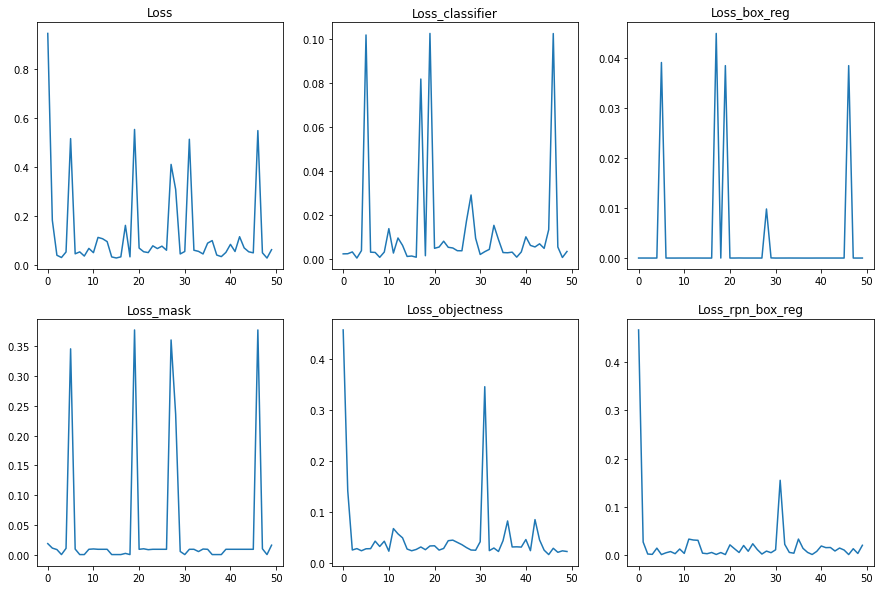

In [53]:
fig, ax = plt.subplots(2,3, figsize=(15,10))

ax[0,0].plot(range(len(logs)),losses)
ax[0,0].set_title('Loss')
ax[0,1].plot(range(len(logs)),losses_class)
ax[0,1].set_title('Loss_classifier')
ax[0,2].plot(range(len(logs)),losses_box_reg)
ax[0,2].set_title('Loss_box_reg')
ax[1,0].plot(range(len(logs)),losses_mask)
ax[1,0].set_title('Loss_mask')
ax[1,1].plot(range(len(logs)),losses_objectness)
ax[1,1].set_title('Loss_objectness')
ax[1,2].plot(range(len(logs)),losses_rpn_box_reg)
ax[1,2].set_title('Loss_rpn_box_reg')

In [52]:
torch.max(predictions[2]['masks'])

tensor(0.0048, device='cuda:0', grad_fn=<MaxBackward1>)

In [ ]:
# torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss,
#             ...
#             }, PATH)

In [33]:
model = model.cpu()

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (lesion) + background
num_classes = 3  # 2 classes (lesion benign + lesion malignant) + background


# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [13]:
predictions

[{'boxes': tensor([[2.5803e+02, 2.3219e+02, 3.9800e+02, 2.9883e+02],
          [1.1064e+02, 1.4831e+02, 1.4184e+02, 1.6377e+02],
          [1.0749e+02, 1.3834e+02, 1.3233e+02, 1.7288e+02],
          [1.5622e+02, 1.9665e+02, 1.8711e+02, 2.1219e+02],
          [1.6788e+02, 1.8433e+02, 1.9201e+02, 2.2053e+02],
          [1.1911e+02, 1.3744e+02, 1.4418e+02, 1.7179e+02],
          [1.7898e+02, 1.8363e+02, 2.0447e+02, 2.1935e+02],
          [1.6970e+02, 1.9679e+02, 2.0021e+02, 2.1216e+02],
          [1.6757e+02, 1.7333e+02, 1.9111e+02, 2.0816e+02],
          [1.5799e+02, 1.8500e+02, 1.8792e+02, 2.0049e+02],
          [1.3170e+02, 1.3631e+02, 1.5699e+02, 1.7156e+02],
          [1.7809e+02, 2.9156e+02, 2.2092e+02, 3.0000e+02],
          [1.3280e+02, 1.4856e+02, 1.6463e+02, 1.6433e+02],
          [1.5361e+02, 2.9105e+02, 1.9505e+02, 3.0000e+02],
          [1.9327e+02, 1.7342e+02, 2.2308e+02, 1.8913e+02],
          [1.8191e+02, 1.9727e+02, 2.1213e+02, 2.1275e+02],
          [1.9056e+02, 1.0140e+

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [10]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [11]:
import utils as vision_utils

In [26]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)
output = model(image_list, target_list)   # Returns losses and detections

# For inference
model.eval()
x = [torch.rand(3,300,400), torch.rand(3,500,400)]
predictions = model(x)           # Returns predictions

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [13]:
predictions

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)}]

In [14]:
output

{'loss_classifier': tensor(0.0169, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0004, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(11.8512, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(35.1903, grad_fn=<DivBackward0>)}